In [1]:
import numpy as np
import os
import argparse
import torch
import torch.optim as optim
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math


import cv2
import torch as tc
import nibabel as nib


from model import ModelWrapper
from utils import DeficitDataset, resize
import random
from scipy.stats import norm

/home/gp/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [15]:
# LOAD THE LESIONS
data = np.load('data/1500_lesions.npy')
# LOAD A PARTICULAR GROUND TRUTH
gt = np.load('data/gt_9.npy')
print(gt.shape)

(32, 32, 32)


In [16]:
# LOAD A TEMPLATE BRAIN FOR VISUALISATION

fp = 'data/avg152T1_brain.nii.gz'
template_brain = nib.load(fp).get_fdata()
template_brain = template_brain[:-1, :-1, :-1]
template_brain = resize(template_brain, (60, 72, 60))

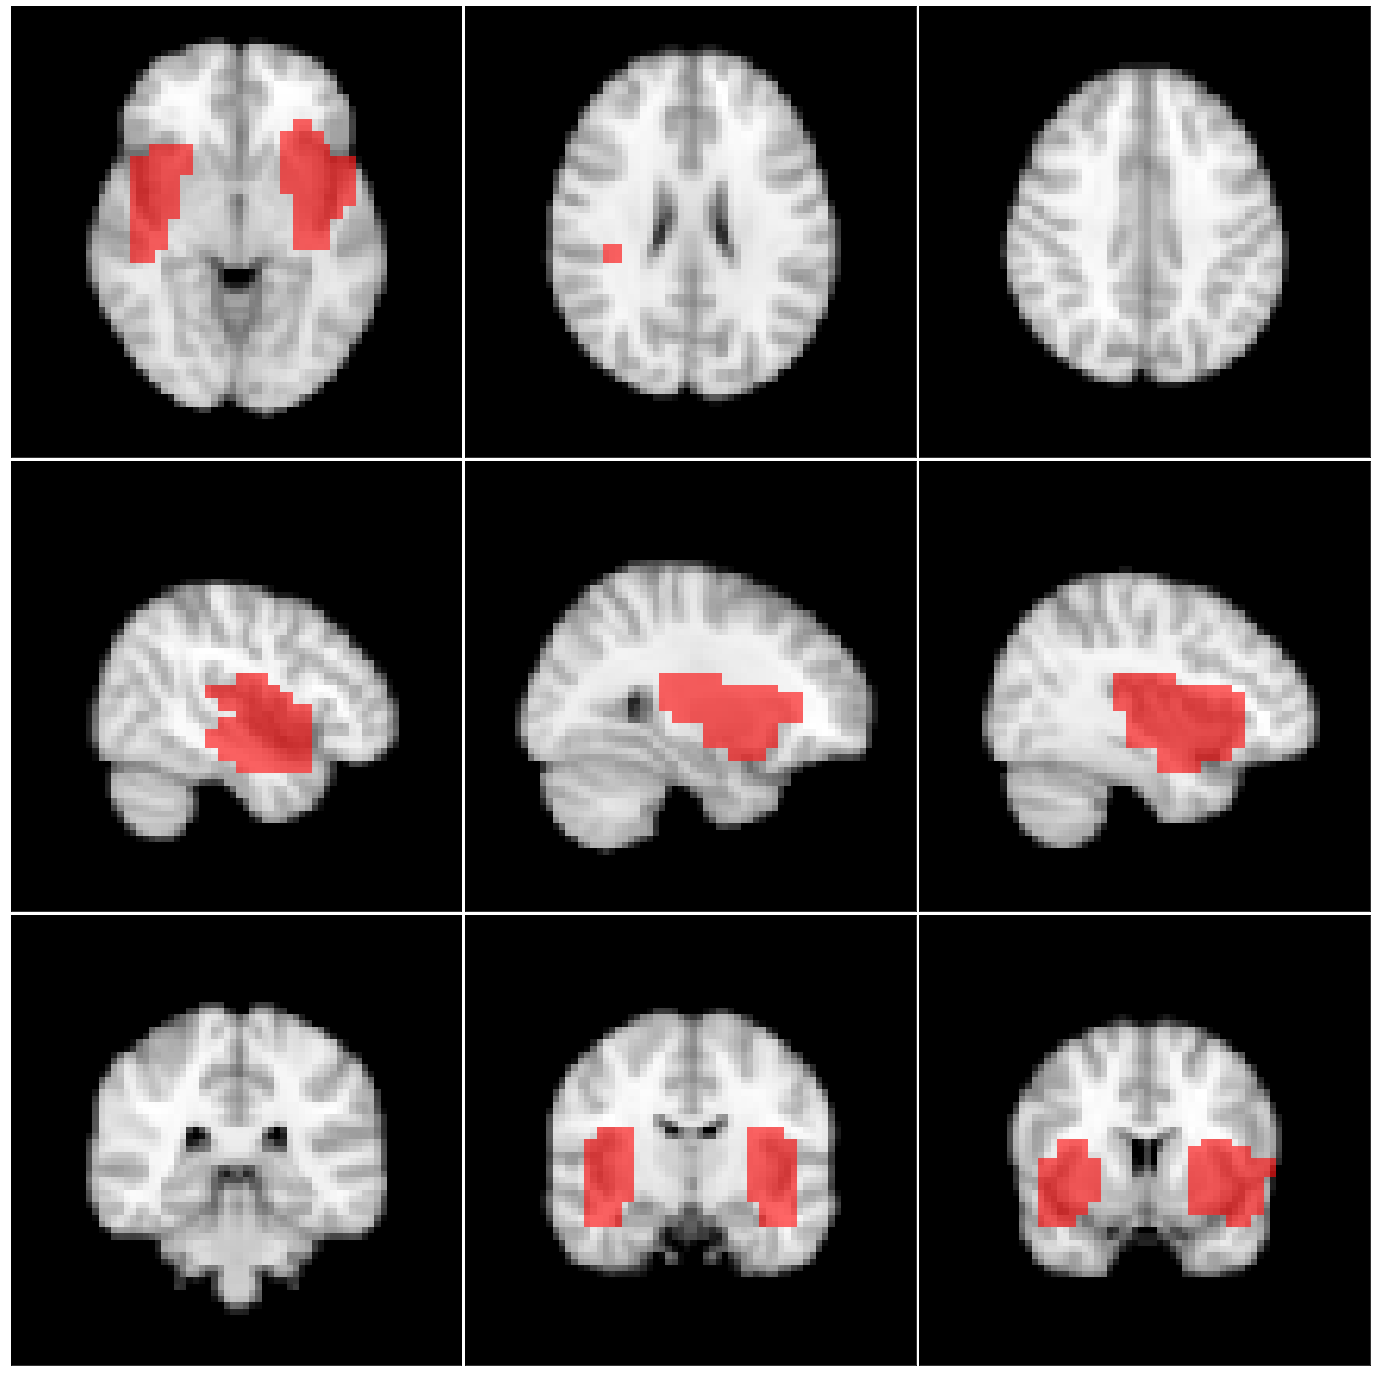

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid
from utils import viz_functional_parcellation

# LET'S VIZUALISE OUR FUNCTIONAL PARCELATION

views = [[22, 32, 37], [15, 20, 42], [30, 38, 45]]
slices_per_view = 3
viz_gt = resize(gt, (60, 72, 60))

fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(len(views), 3),
                 axes_pad=0.05,
                 share_all=True
                 )

grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

acc = 0
for v_idx, v in enumerate(views):
    for slice_idx in range(slices_per_view):
        viz_functional_parcellation(viz_gt, grid[acc], v_idx, v[slice_idx],
                                    template_brain)
        acc += 1

(array([252., 254., 305., 268., 286.,  65.,  32.,  22.,  12.,   4.]),
 array([0.   , 0.061, 0.122, 0.183, 0.244, 0.305, 0.366, 0.427, 0.488,
        0.549, 0.61 ]),
 <BarContainer object of 10 artists>)

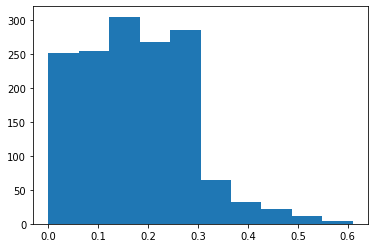

In [17]:
# LET'S SIMULATE SOME SCORES

# THIS IS THE AMOUNT OF NOISE TO ADD, USUALLY THERE WON'T BE CLEAN RELATIONSHIPS
noise = 0.3

# WE SIMULATE A CONTINUOUS SCORE BY TAKING THE OVERLAP OF THE LESION AND FUNCTIONAL PARCEL

disease = [0 for i in range(len(data))]
positive_indices = []
for i in range(len(data)):
    overlap = data[i] * gt
    counts = np.count_nonzero(overlap)
    voxels_gt = np.sum(gt)
    ratio_lesion = counts / voxels_gt

    disease[i] = ratio_lesion 
    
    if noise > 0:
        vox_noise = np.random.uniform(0, 1)
        disease[i] = (1- noise) * disease[i] + noise * vox_noise

    disease[i] = round(disease[i], 2)
                
    

disease = np.array(disease)
plt.hist(disease)

In [6]:
# CREATE VALIDATION AND TRAIN
len_train = int(0.9 * 500)
len_val = int(0.1 * 500)

indices = [i for i in range(len(data))]
np.random.shuffle(indices)

data = data[indices]
disease = disease[indices]

train_data = data[:len_train]
train_labels = disease[:len_train]
train_data = np.expand_dims(train_data, axis=1)

val_data = data[len_train:(len_train+len_val)]
val_labels = disease[len_train:(len_train+len_val)]
val_data = np.expand_dims(val_data, axis=1)

np.count_nonzero(train_labels) / len(train_labels)

0.9911111111111112

In [7]:
from torch.utils.data import Dataset, DataLoader

batch_size = 256

# NORMALISE LABELS FIRST
n_train_labels = (train_labels - disease.mean()) / disease.std()
n_val_labels = (val_labels - disease.mean()) / disease.std()

# CREATE DATA LOADERS
dataset = DeficitDataset(data=train_data, labels=n_train_labels)
train_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=True)

val_dataset = DeficitDataset(data=val_data, labels=n_val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=True)


device = torch.device("cuda:0")

In [8]:
# DEFINE A MODEL CONFIGURATION
config = dict(input_size=32, z_dim=128, start_dims=16, continuous=True,
              epochs=500, wd=1e-4, lr=1e-3)

CONTINUOUS MODEL: True


/home/gp/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


NUM PARAMS: 3779763
NUM EPOCHS: 500
Epoch: 0, mask likelihood: 1.4145073890686035, KL: 2.455, accuracy: 1.4145, recon likelihood: 15424.4150390625
Best: 1.4145073890686035, 15428.2841796875, 1.4145, epoch: 0


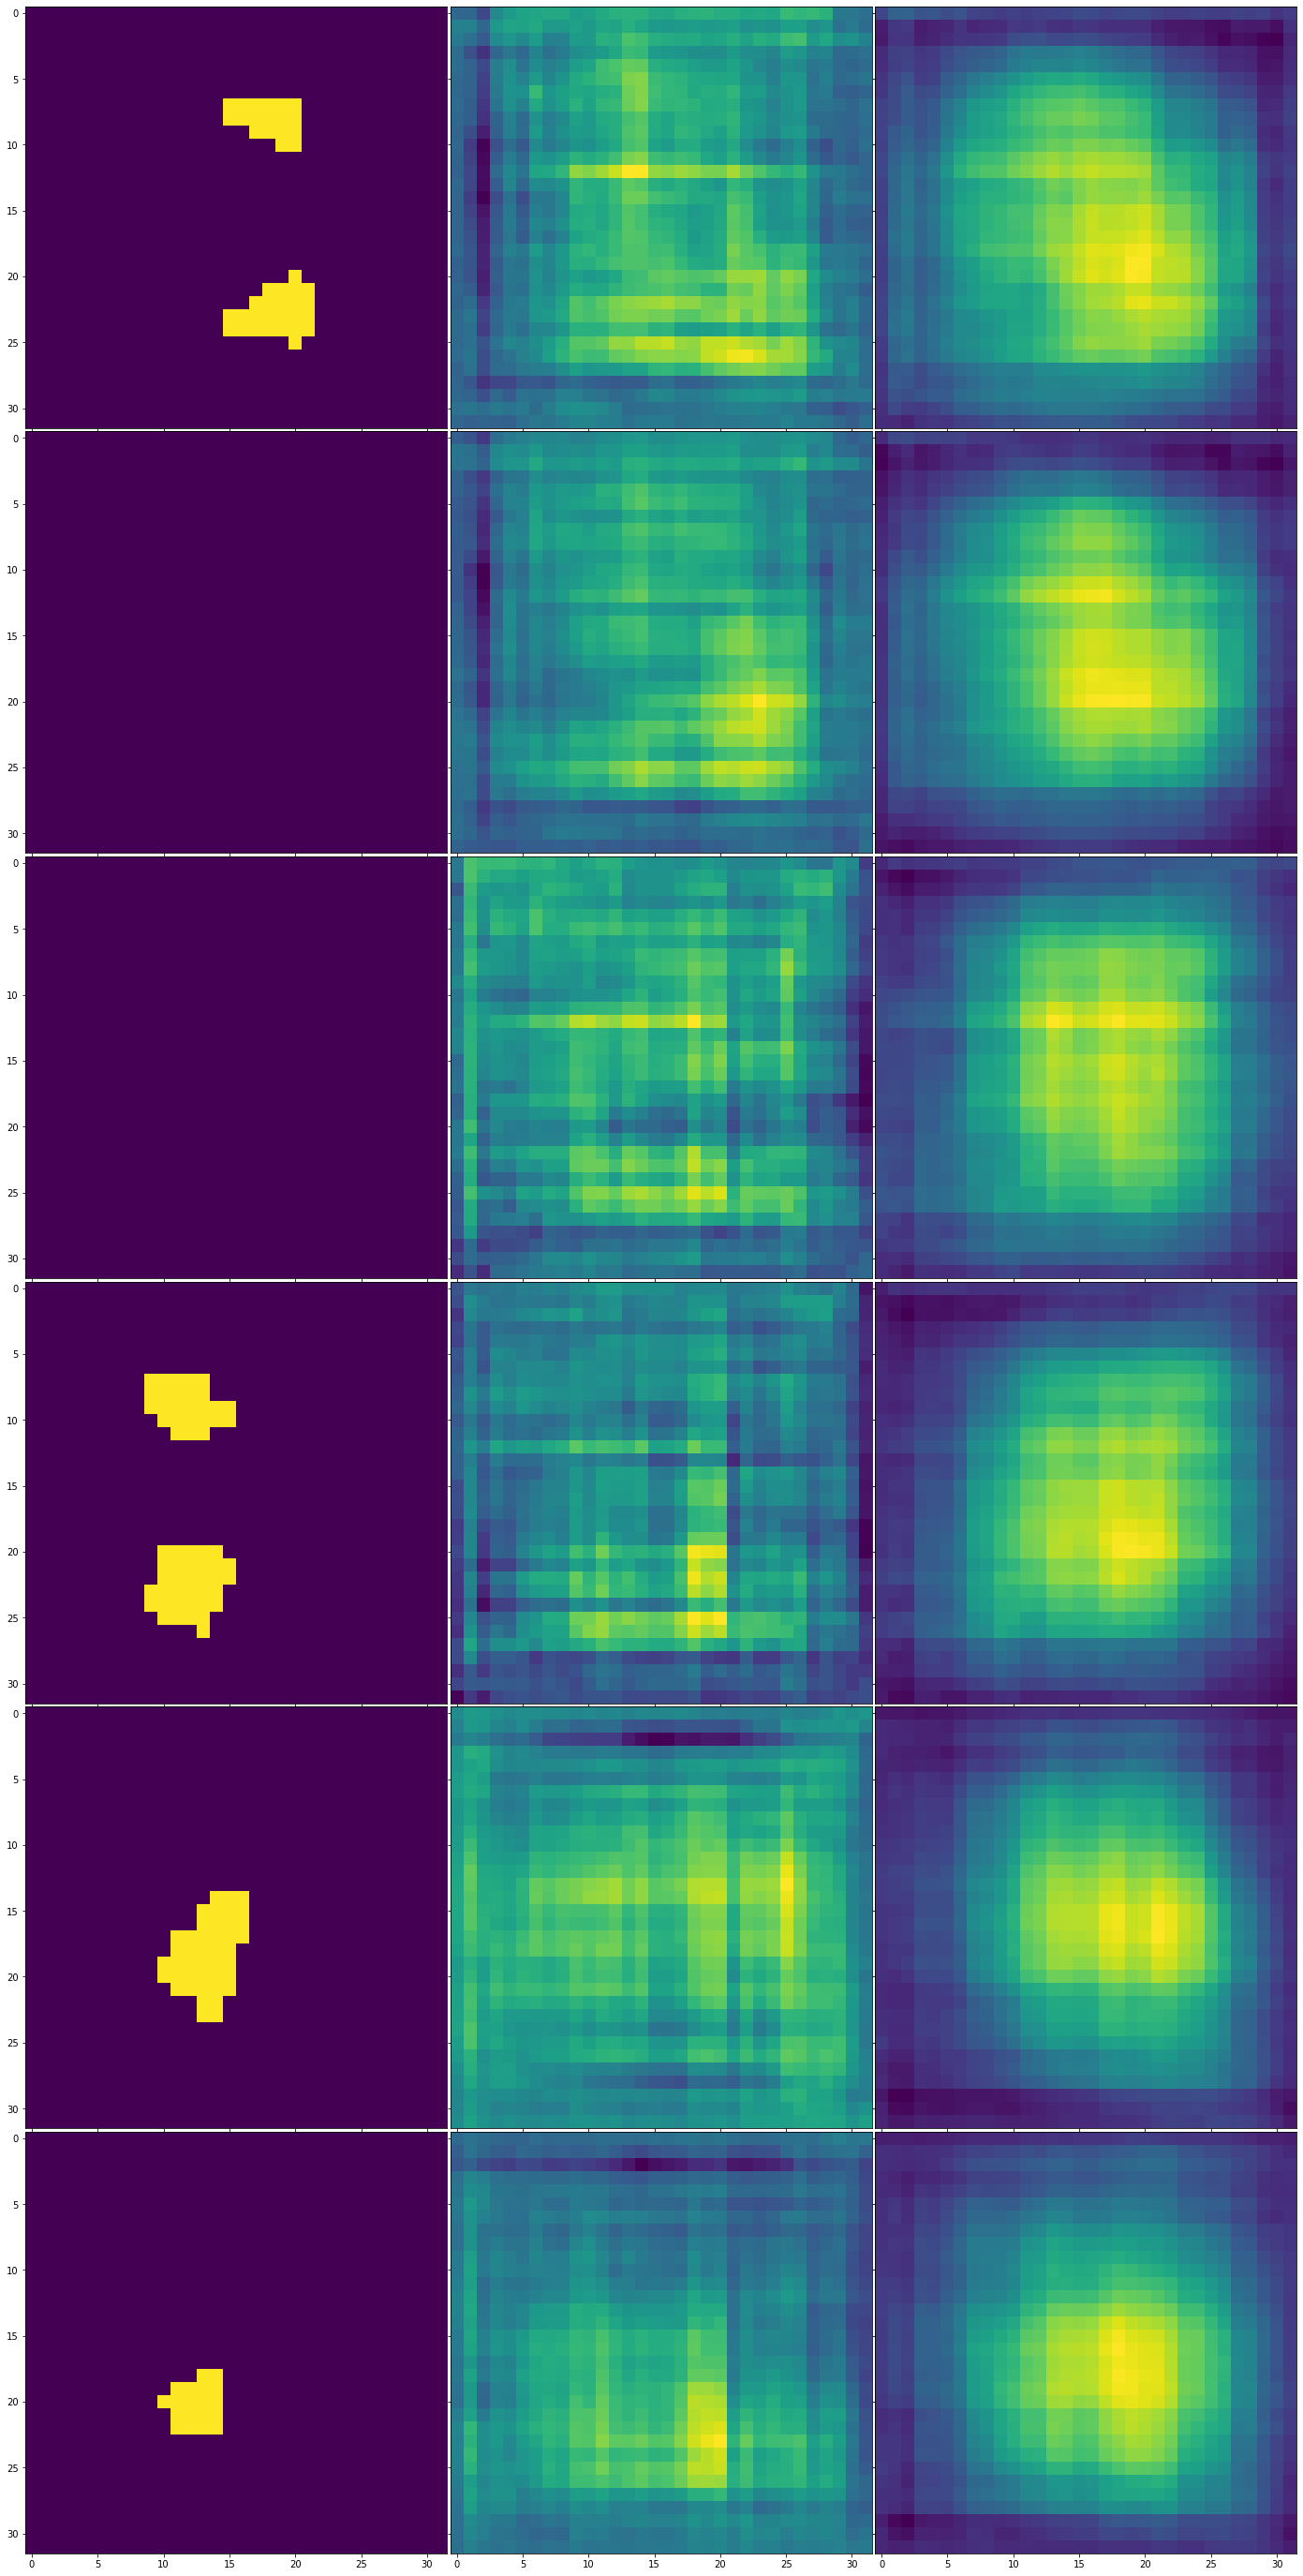

Epoch: 1, mask likelihood: 1.413269281387329, KL: 4.082, accuracy: 1.4133, recon likelihood: 13510.4912109375
Epoch: 2, mask likelihood: 1.4120699167251587, KL: 5.828, accuracy: 1.4121, recon likelihood: 11904.7880859375
Epoch: 3, mask likelihood: 1.411327600479126, KL: 7.064, accuracy: 1.4113, recon likelihood: 10426.5107421875
Epoch: 4, mask likelihood: 1.4092276096343994, KL: 8.095, accuracy: 1.4092, recon likelihood: 9072.0859375
Epoch: 5, mask likelihood: 1.405587077140808, KL: 8.871, accuracy: 1.4056, recon likelihood: 7849.759765625
Epoch: 6, mask likelihood: 1.4013028144836426, KL: 9.442, accuracy: 1.4013, recon likelihood: 6785.33349609375
Epoch: 7, mask likelihood: 1.3990955352783203, KL: 9.875, accuracy: 1.3991, recon likelihood: 5860.10107421875
Epoch: 8, mask likelihood: 1.4006295204162598, KL: 10.269, accuracy: 1.4006, recon likelihood: 5089.58447265625
Epoch: 9, mask likelihood: 1.4001787900924683, KL: 10.499, accuracy: 1.4002, recon likelihood: 4431.66455078125
Epoch: 1

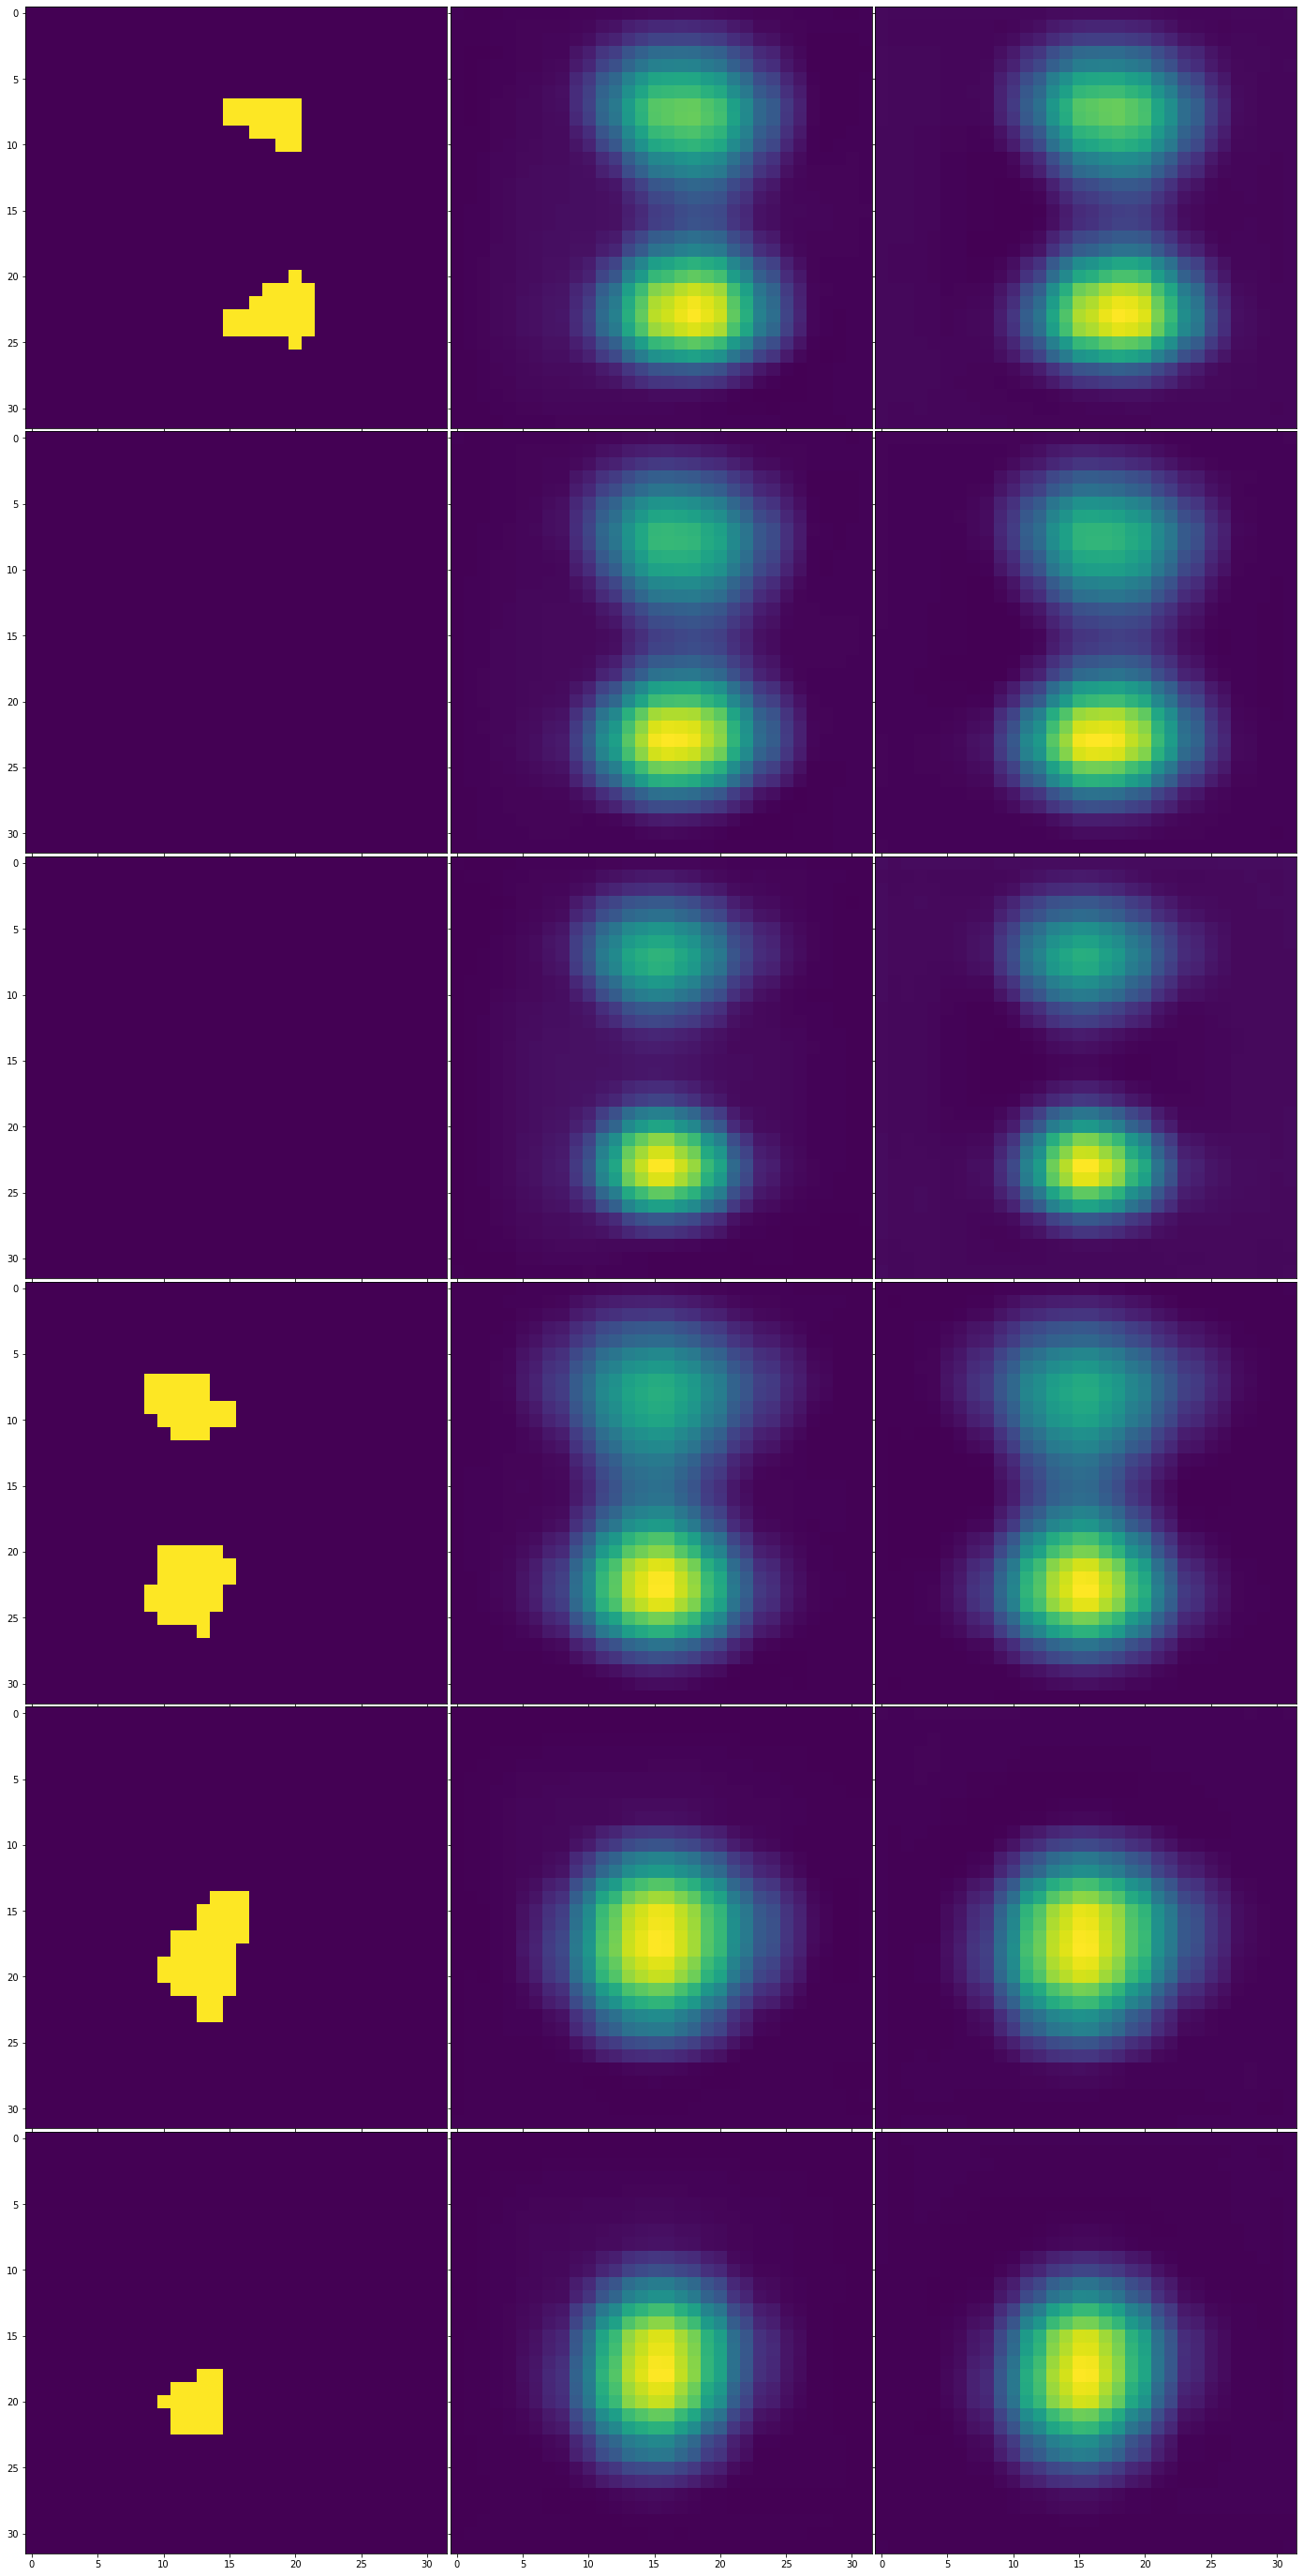

Epoch: 21, mask likelihood: 1.3801095485687256, KL: 9.654, accuracy: 1.3801, recon likelihood: 1481.6368408203125
Epoch: 22, mask likelihood: 1.3820430040359497, KL: 9.419, accuracy: 1.382, recon likelihood: 1405.9921875
Epoch: 23, mask likelihood: 1.3829271793365479, KL: 9.184, accuracy: 1.3829, recon likelihood: 1359.60546875
Epoch: 24, mask likelihood: 1.38227379322052, KL: 8.937, accuracy: 1.3823, recon likelihood: 1308.6297607421875
Epoch: 25, mask likelihood: 1.3819013833999634, KL: 8.685, accuracy: 1.3819, recon likelihood: 1253.42041015625
Epoch: 26, mask likelihood: 1.37871515750885, KL: 8.509, accuracy: 1.3787, recon likelihood: 1207.5340576171875
Epoch: 27, mask likelihood: 1.3754992485046387, KL: 8.355, accuracy: 1.3755, recon likelihood: 1164.5623779296875
Epoch: 28, mask likelihood: 1.3736928701400757, KL: 8.184, accuracy: 1.3737, recon likelihood: 1140.3111572265625
Epoch: 29, mask likelihood: 1.3737096786499023, KL: 7.978, accuracy: 1.3737, recon likelihood: 1111.953857

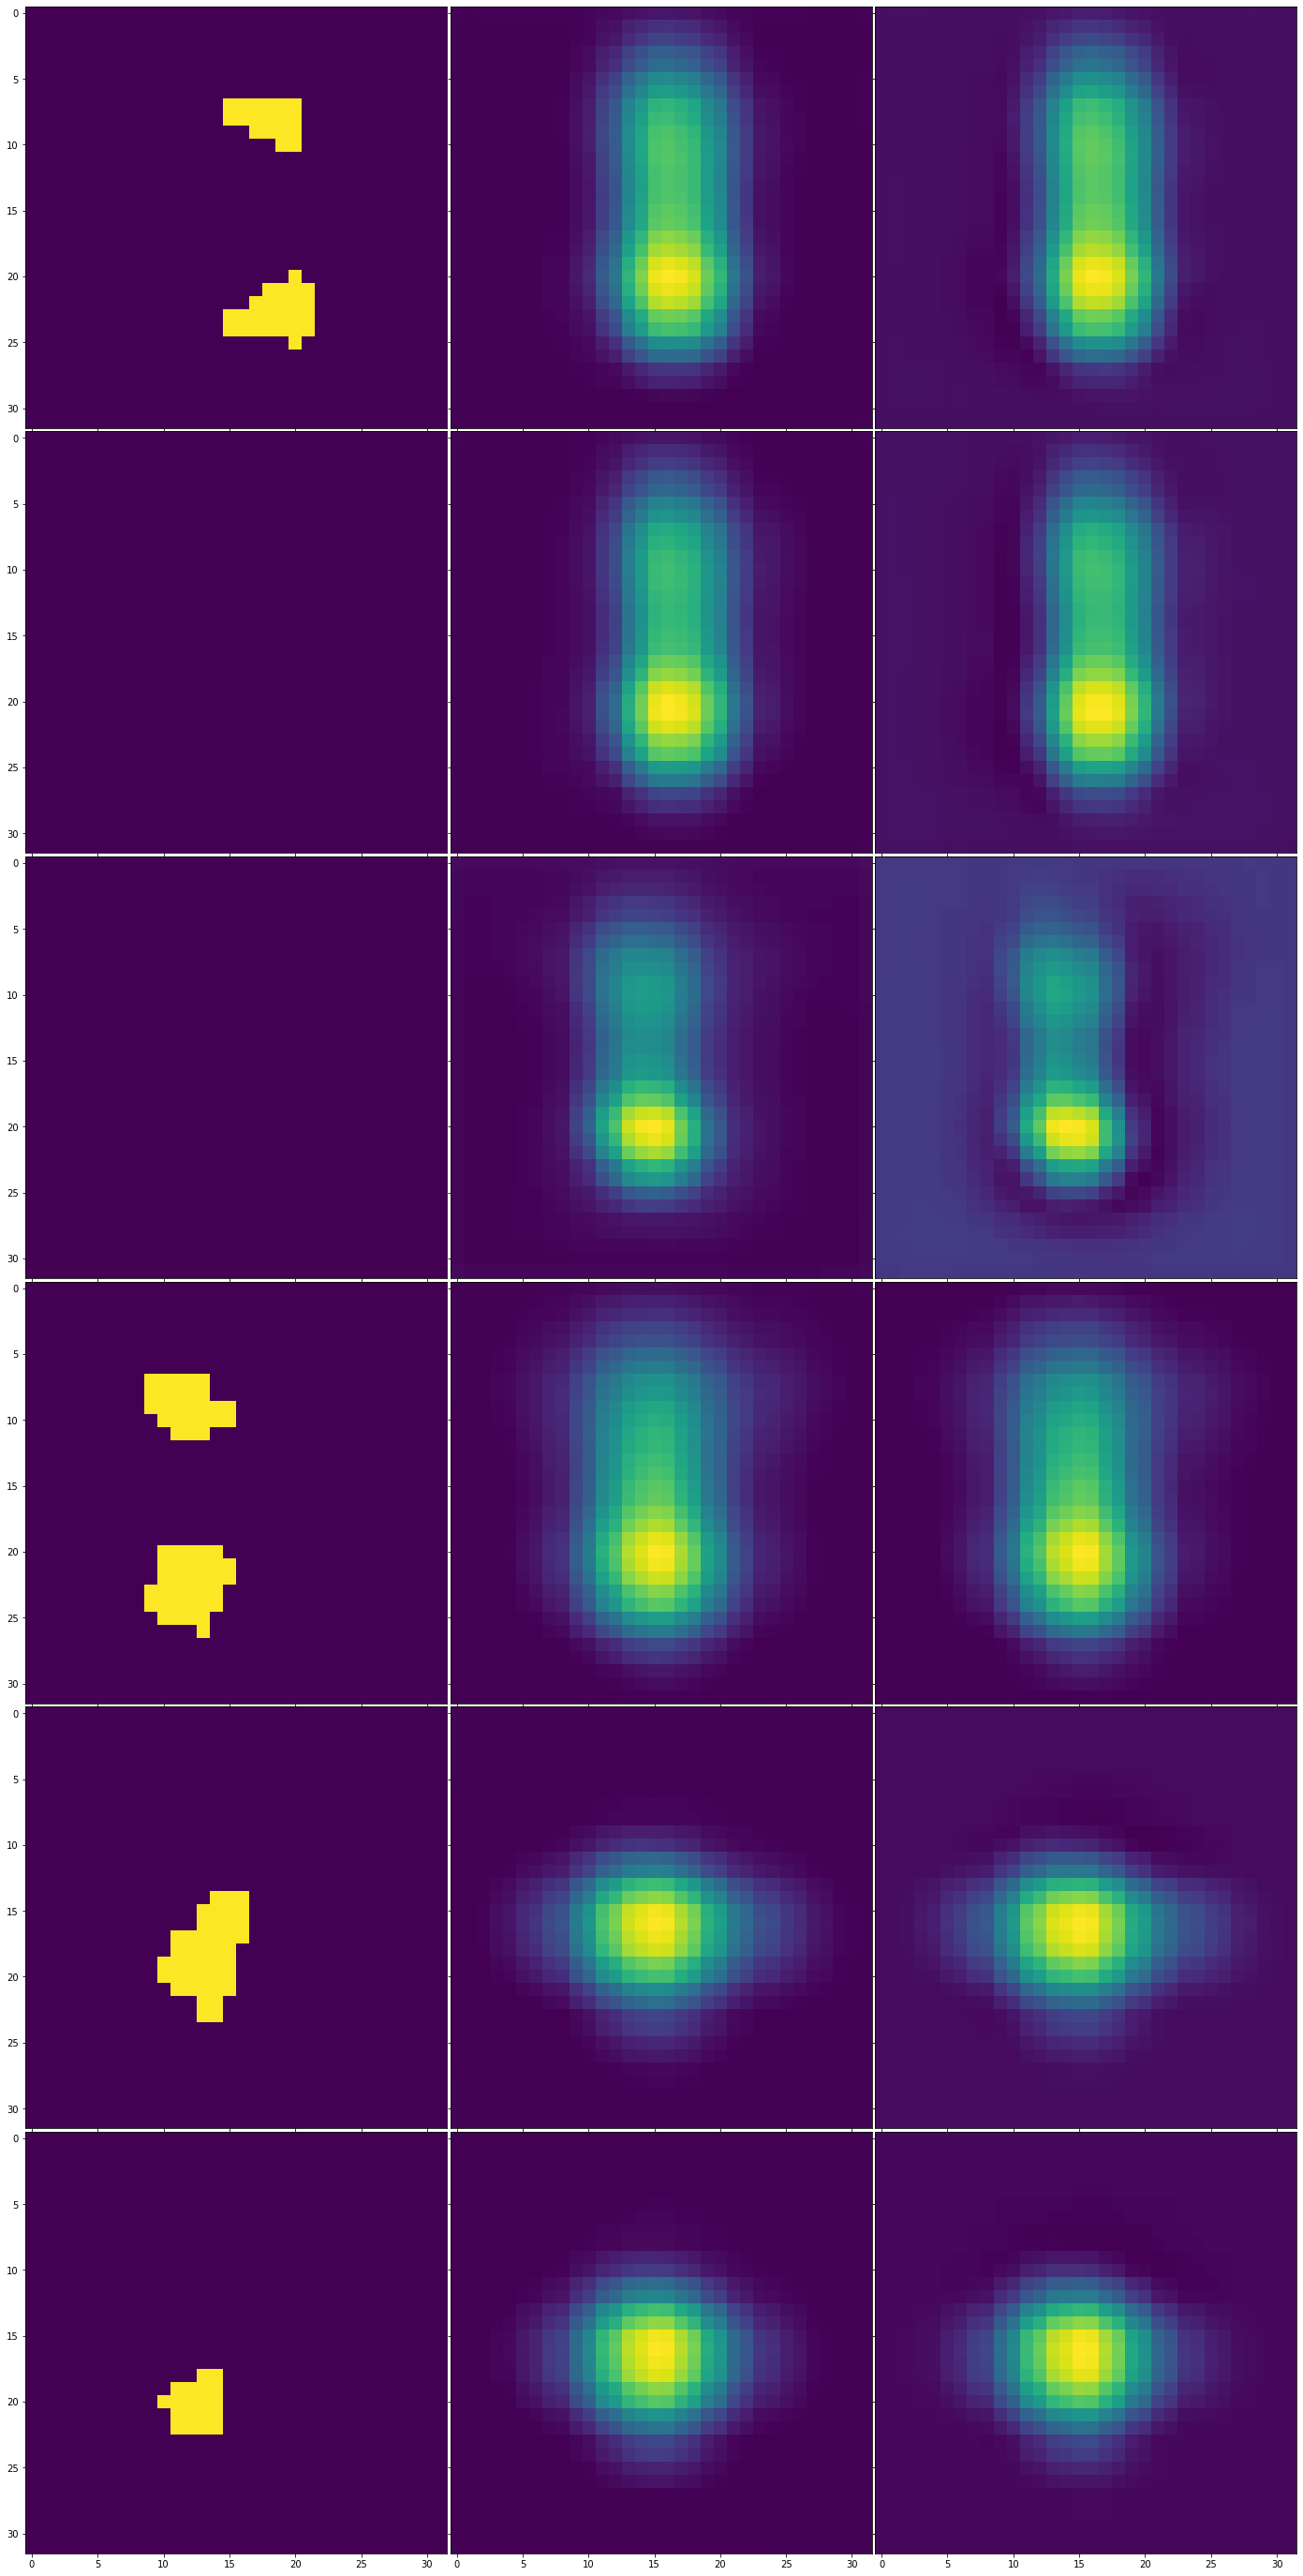

Epoch: 41, mask likelihood: 1.380564570426941, KL: 6.794, accuracy: 1.3806, recon likelihood: 917.599853515625
Epoch: 42, mask likelihood: 1.3804707527160645, KL: 6.764, accuracy: 1.3805, recon likelihood: 906.671875
Epoch: 43, mask likelihood: 1.3792574405670166, KL: 6.7, accuracy: 1.3793, recon likelihood: 905.84130859375
Epoch: 44, mask likelihood: 1.3783953189849854, KL: 6.648, accuracy: 1.3784, recon likelihood: 900.8331298828125
Epoch: 45, mask likelihood: 1.3756368160247803, KL: 6.644, accuracy: 1.3756, recon likelihood: 896.8842163085938
Epoch: 46, mask likelihood: 1.375899076461792, KL: 6.648, accuracy: 1.3759, recon likelihood: 880.080078125
Epoch: 47, mask likelihood: 1.3742843866348267, KL: 6.619, accuracy: 1.3743, recon likelihood: 868.8815307617188
Epoch: 48, mask likelihood: 1.3739107847213745, KL: 6.555, accuracy: 1.3739, recon likelihood: 856.192138671875
Epoch: 49, mask likelihood: 1.375538945198059, KL: 6.502, accuracy: 1.3755, recon likelihood: 864.1959228515625
Epo

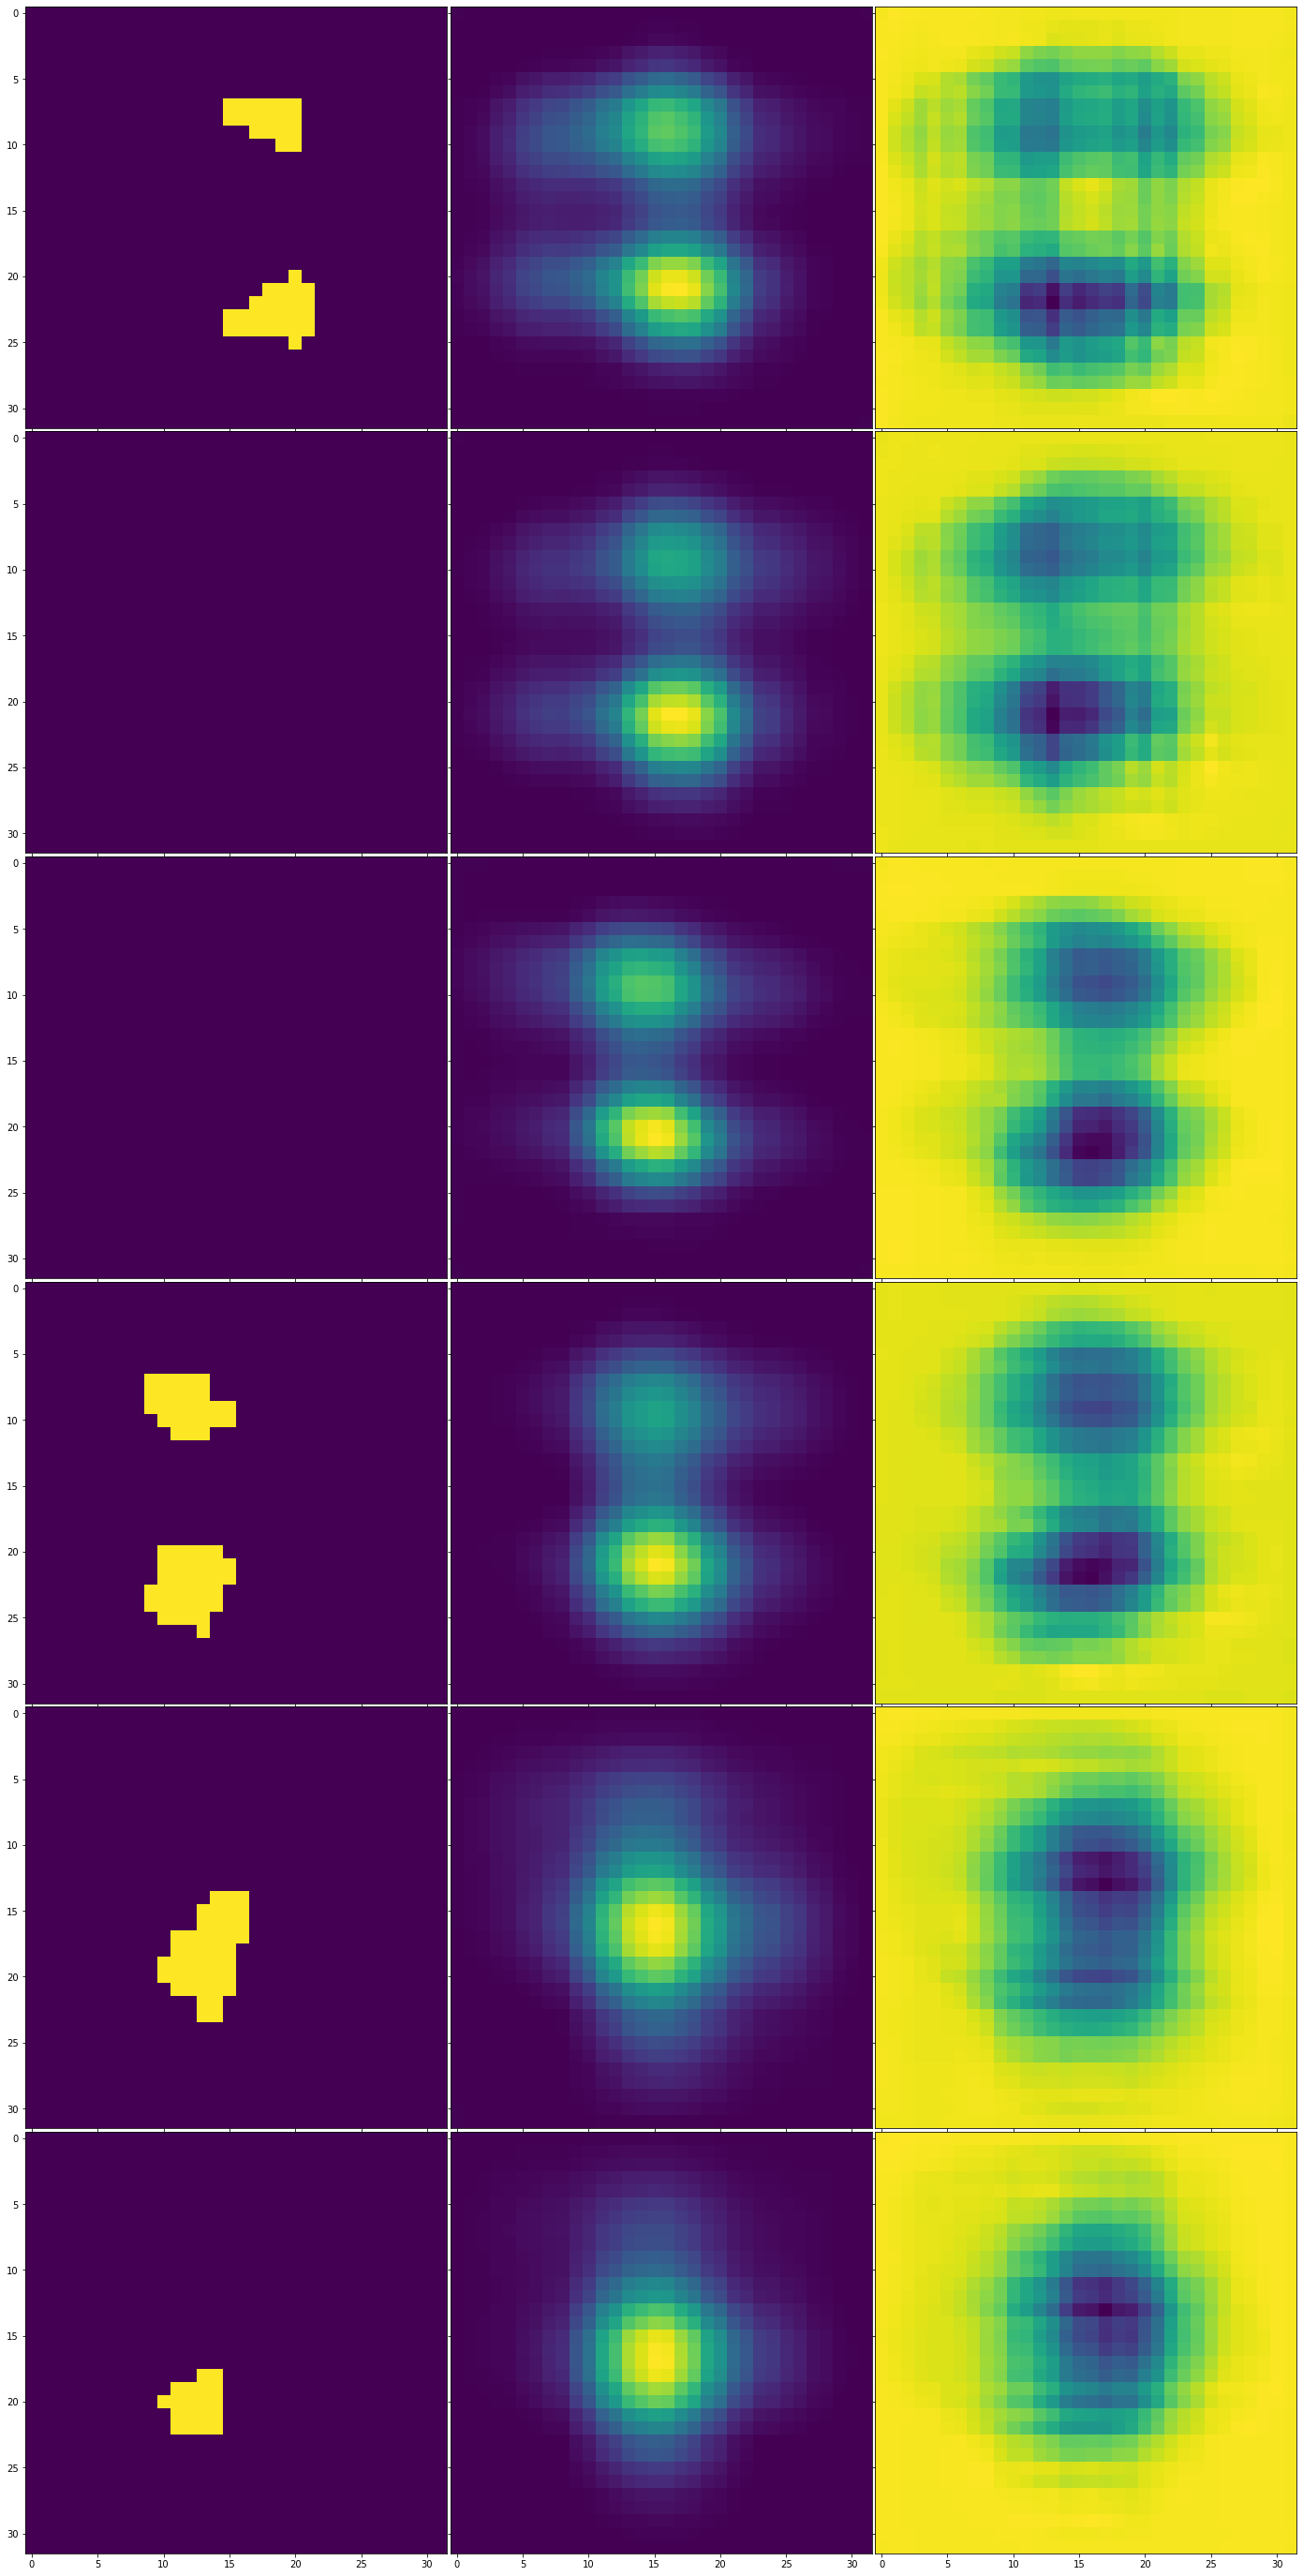

Epoch: 61, mask likelihood: 1.3711340427398682, KL: 6.169, accuracy: 1.3711, recon likelihood: 762.5913696289062
Epoch: 62, mask likelihood: 1.373556137084961, KL: 6.393, accuracy: 1.3736, recon likelihood: 767.1221923828125
Epoch: 63, mask likelihood: 1.3720436096191406, KL: 6.541, accuracy: 1.372, recon likelihood: 765.74951171875
Epoch: 64, mask likelihood: 1.370395302772522, KL: 6.592, accuracy: 1.3704, recon likelihood: 749.577880859375
Epoch: 65, mask likelihood: 1.3690427541732788, KL: 6.497, accuracy: 1.369, recon likelihood: 739.1404418945312
Epoch: 66, mask likelihood: 1.3714900016784668, KL: 6.511, accuracy: 1.3715, recon likelihood: 748.730224609375
Epoch: 67, mask likelihood: 1.370819091796875, KL: 6.541, accuracy: 1.3708, recon likelihood: 746.1160888671875
Epoch: 68, mask likelihood: 1.3647931814193726, KL: 6.471, accuracy: 1.3648, recon likelihood: 758.59912109375
Epoch: 69, mask likelihood: 1.3646219968795776, KL: 6.399, accuracy: 1.3646, recon likelihood: 747.63372802

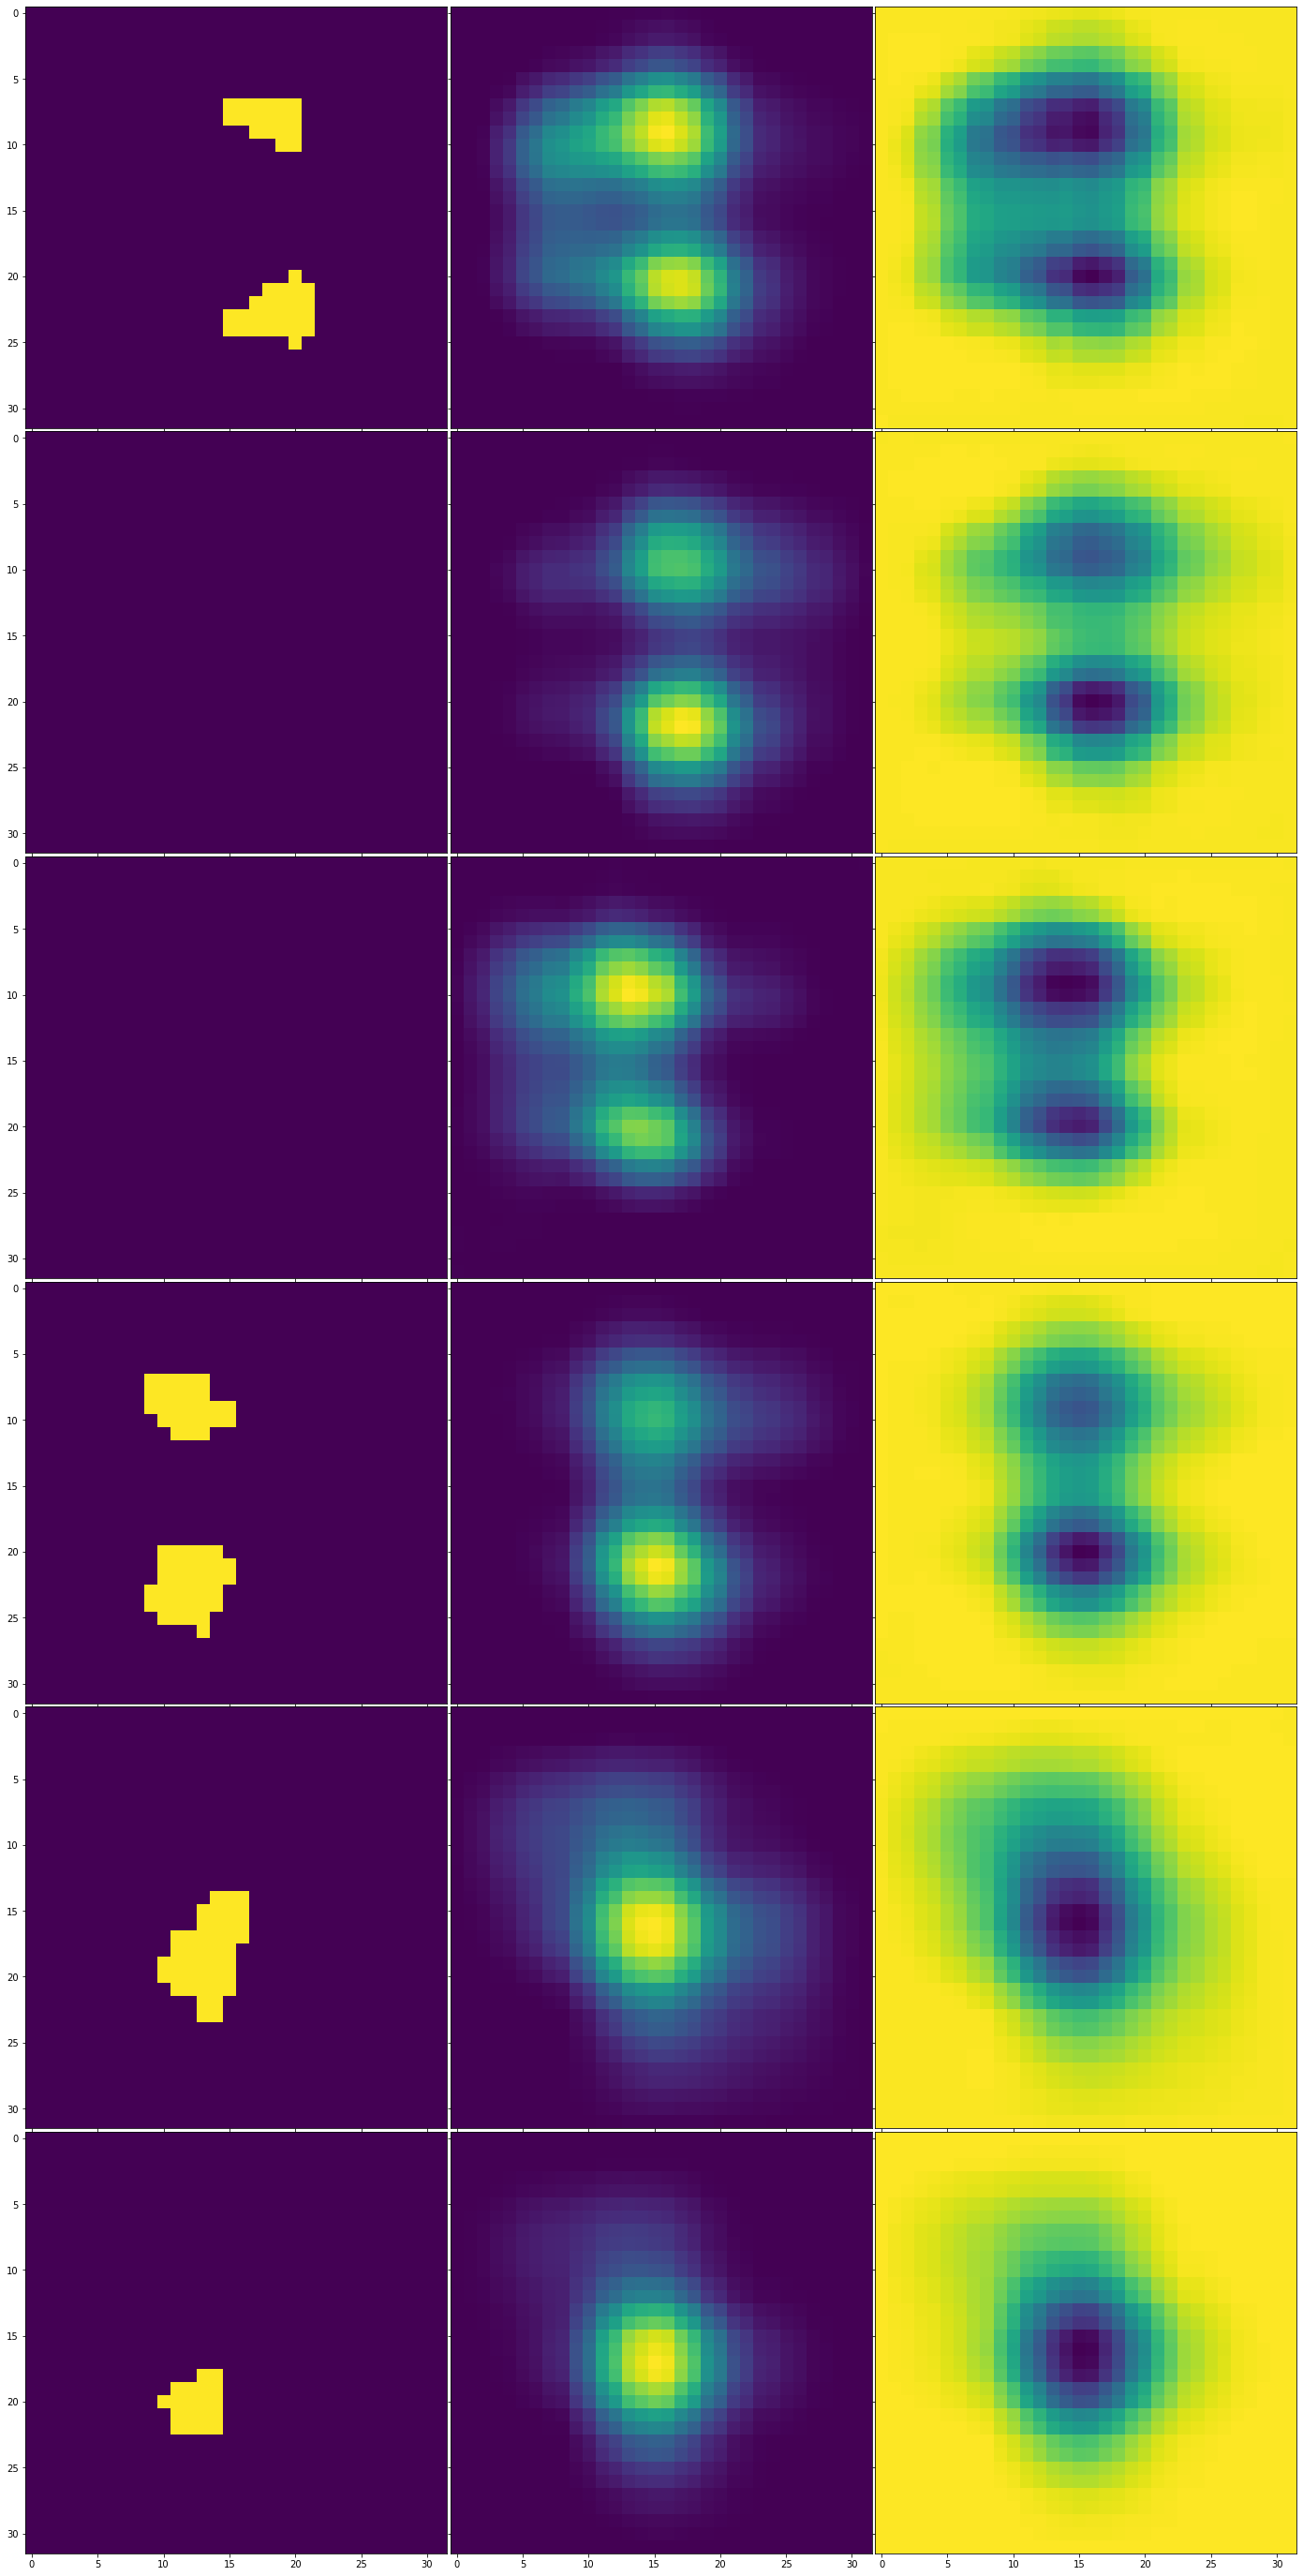

Epoch: 81, mask likelihood: 1.357931137084961, KL: 6.058, accuracy: 1.3579, recon likelihood: 675.8658447265625
Epoch: 82, mask likelihood: 1.359466552734375, KL: 6.134, accuracy: 1.3595, recon likelihood: 663.1467895507812
Epoch: 83, mask likelihood: 1.3569586277008057, KL: 6.267, accuracy: 1.357, recon likelihood: 670.868408203125
Epoch: 84, mask likelihood: 1.3570716381072998, KL: 6.266, accuracy: 1.3571, recon likelihood: 653.8356323242188
Epoch: 85, mask likelihood: 1.3607041835784912, KL: 6.352, accuracy: 1.3607, recon likelihood: 656.728515625
Epoch: 86, mask likelihood: 1.3641819953918457, KL: 6.504, accuracy: 1.3642, recon likelihood: 657.3275146484375
Epoch: 87, mask likelihood: 1.3634039163589478, KL: 6.439, accuracy: 1.3634, recon likelihood: 642.5377197265625
Epoch: 88, mask likelihood: 1.3617818355560303, KL: 6.505, accuracy: 1.3618, recon likelihood: 647.5478515625
Epoch: 89, mask likelihood: 1.3594233989715576, KL: 6.719, accuracy: 1.3594, recon likelihood: 650.52331542

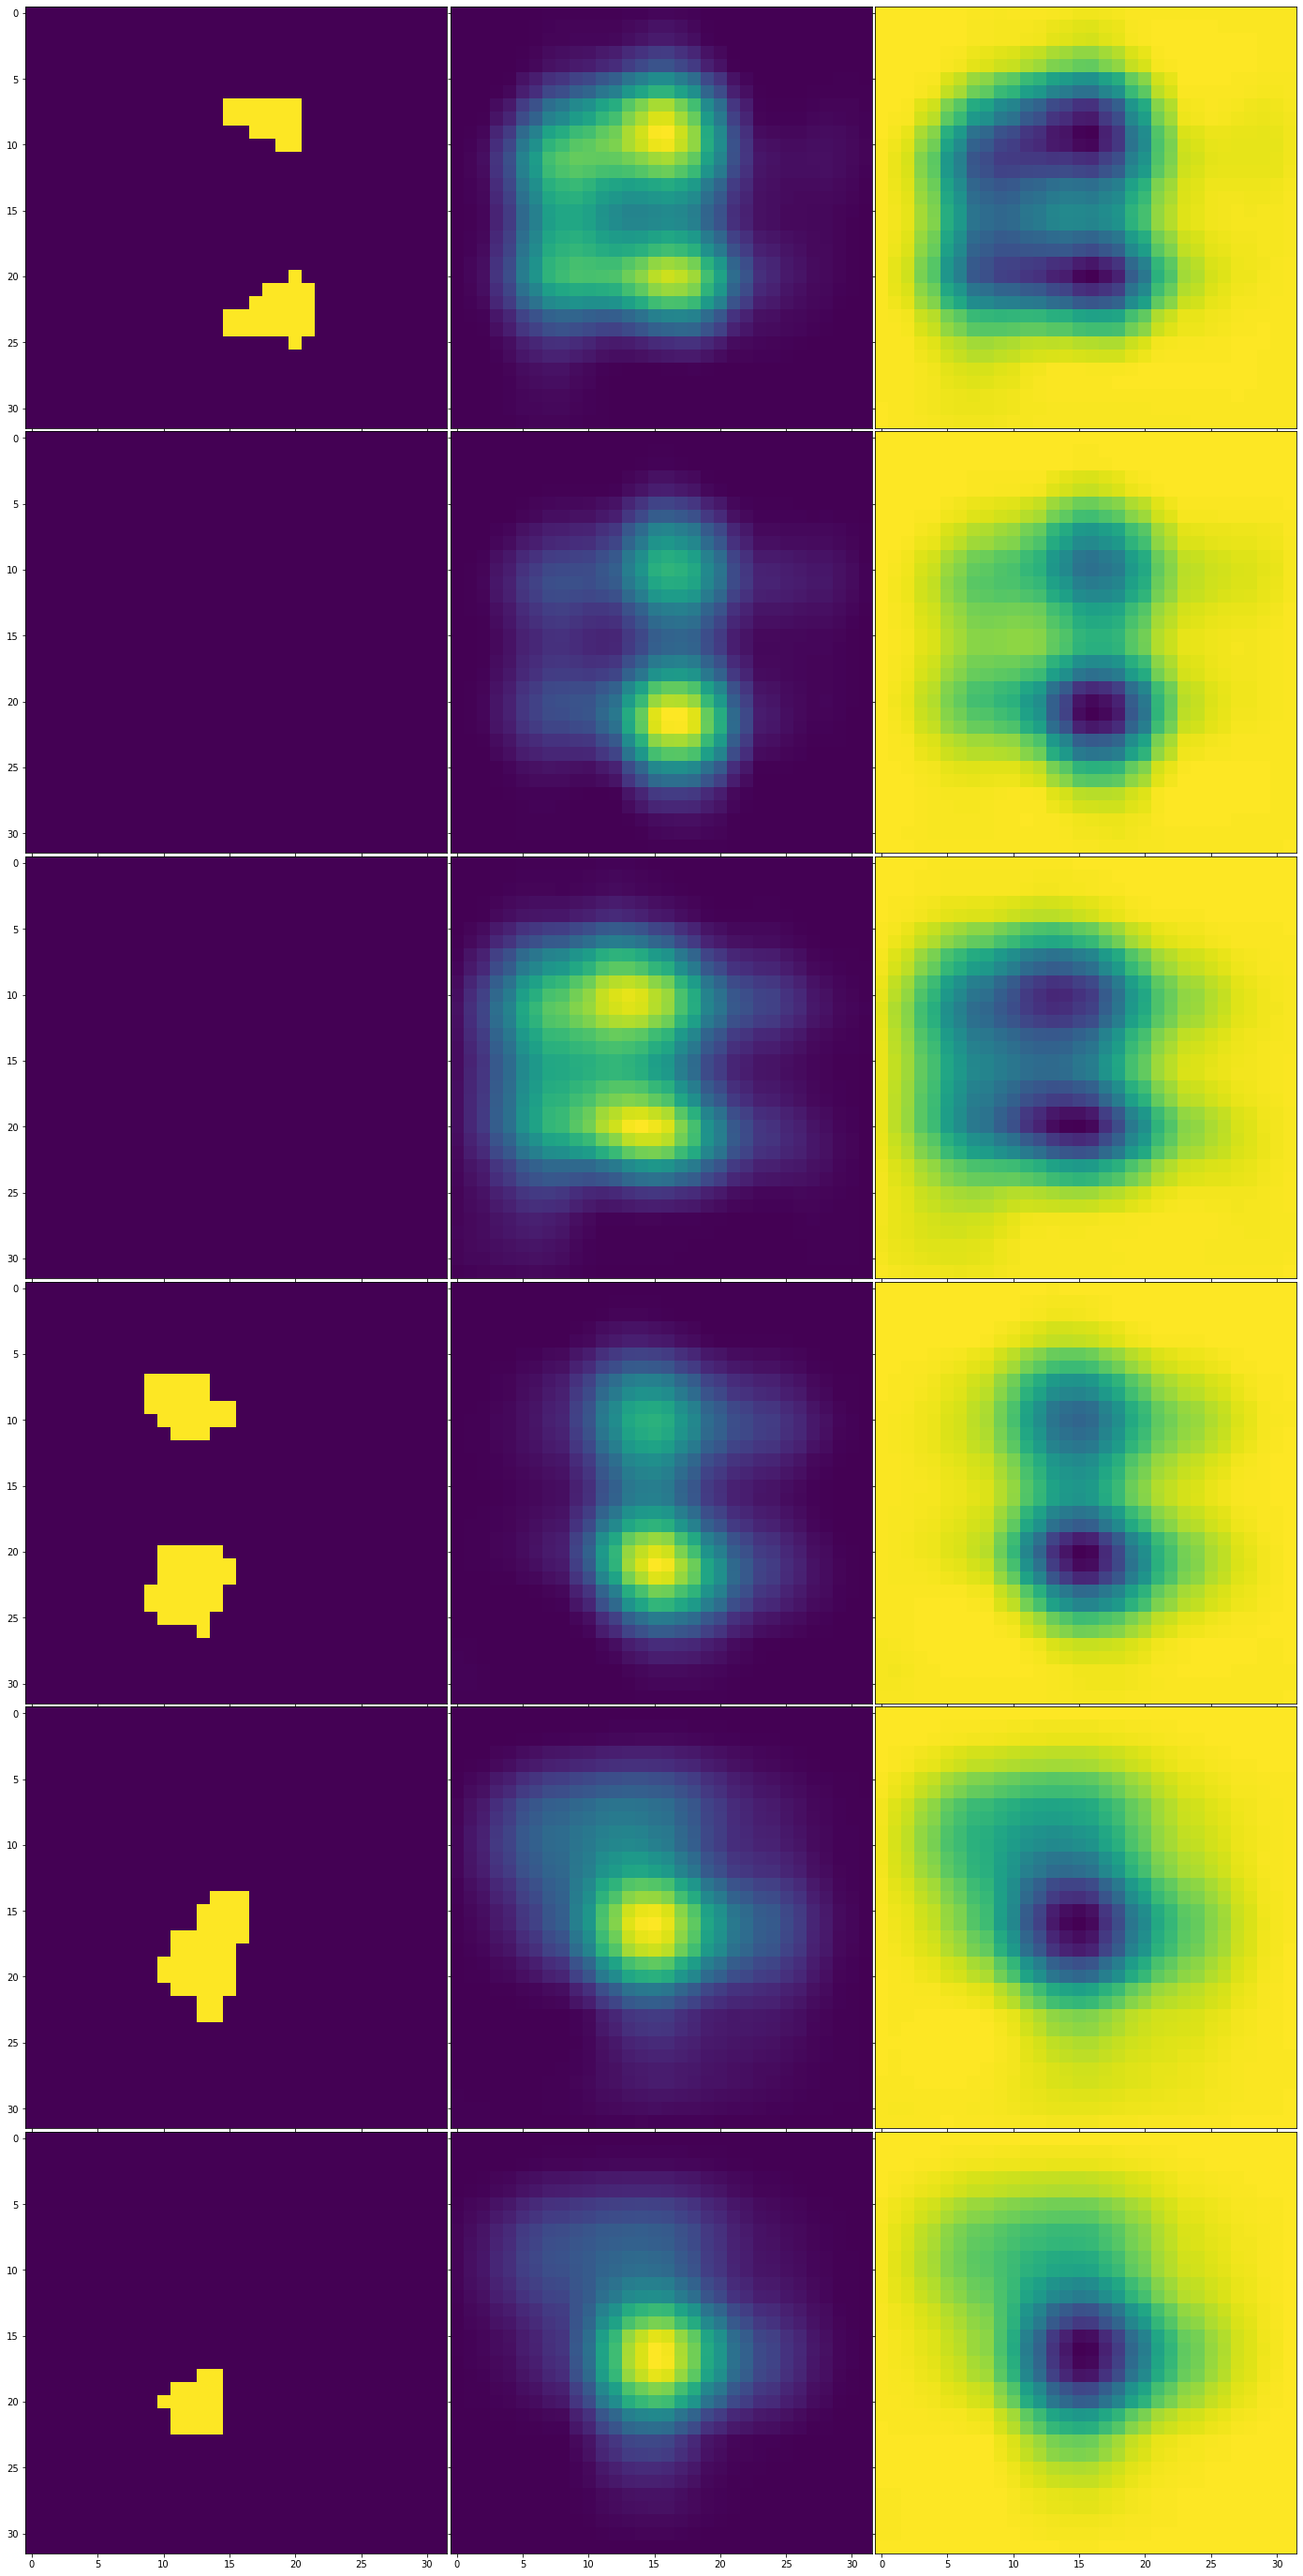

Epoch: 101, mask likelihood: 1.3590948581695557, KL: 6.745, accuracy: 1.3591, recon likelihood: 597.9320068359375
Epoch: 102, mask likelihood: 1.3574203252792358, KL: 6.797, accuracy: 1.3574, recon likelihood: 600.2330322265625
Epoch: 103, mask likelihood: 1.3583537340164185, KL: 6.891, accuracy: 1.3584, recon likelihood: 601.0265502929688
Epoch: 104, mask likelihood: 1.354785680770874, KL: 7.13, accuracy: 1.3548, recon likelihood: 591.7191162109375
Epoch: 105, mask likelihood: 1.3558605909347534, KL: 7.251, accuracy: 1.3559, recon likelihood: 602.1155395507812
Epoch: 106, mask likelihood: 1.3540217876434326, KL: 6.996, accuracy: 1.354, recon likelihood: 606.458251953125
Epoch: 107, mask likelihood: 1.3549282550811768, KL: 7.088, accuracy: 1.3549, recon likelihood: 590.4154663085938
Epoch: 108, mask likelihood: 1.357720971107483, KL: 7.199, accuracy: 1.3577, recon likelihood: 584.7374877929688
Epoch: 109, mask likelihood: 1.3595867156982422, KL: 7.232, accuracy: 1.3596, recon likelihoo

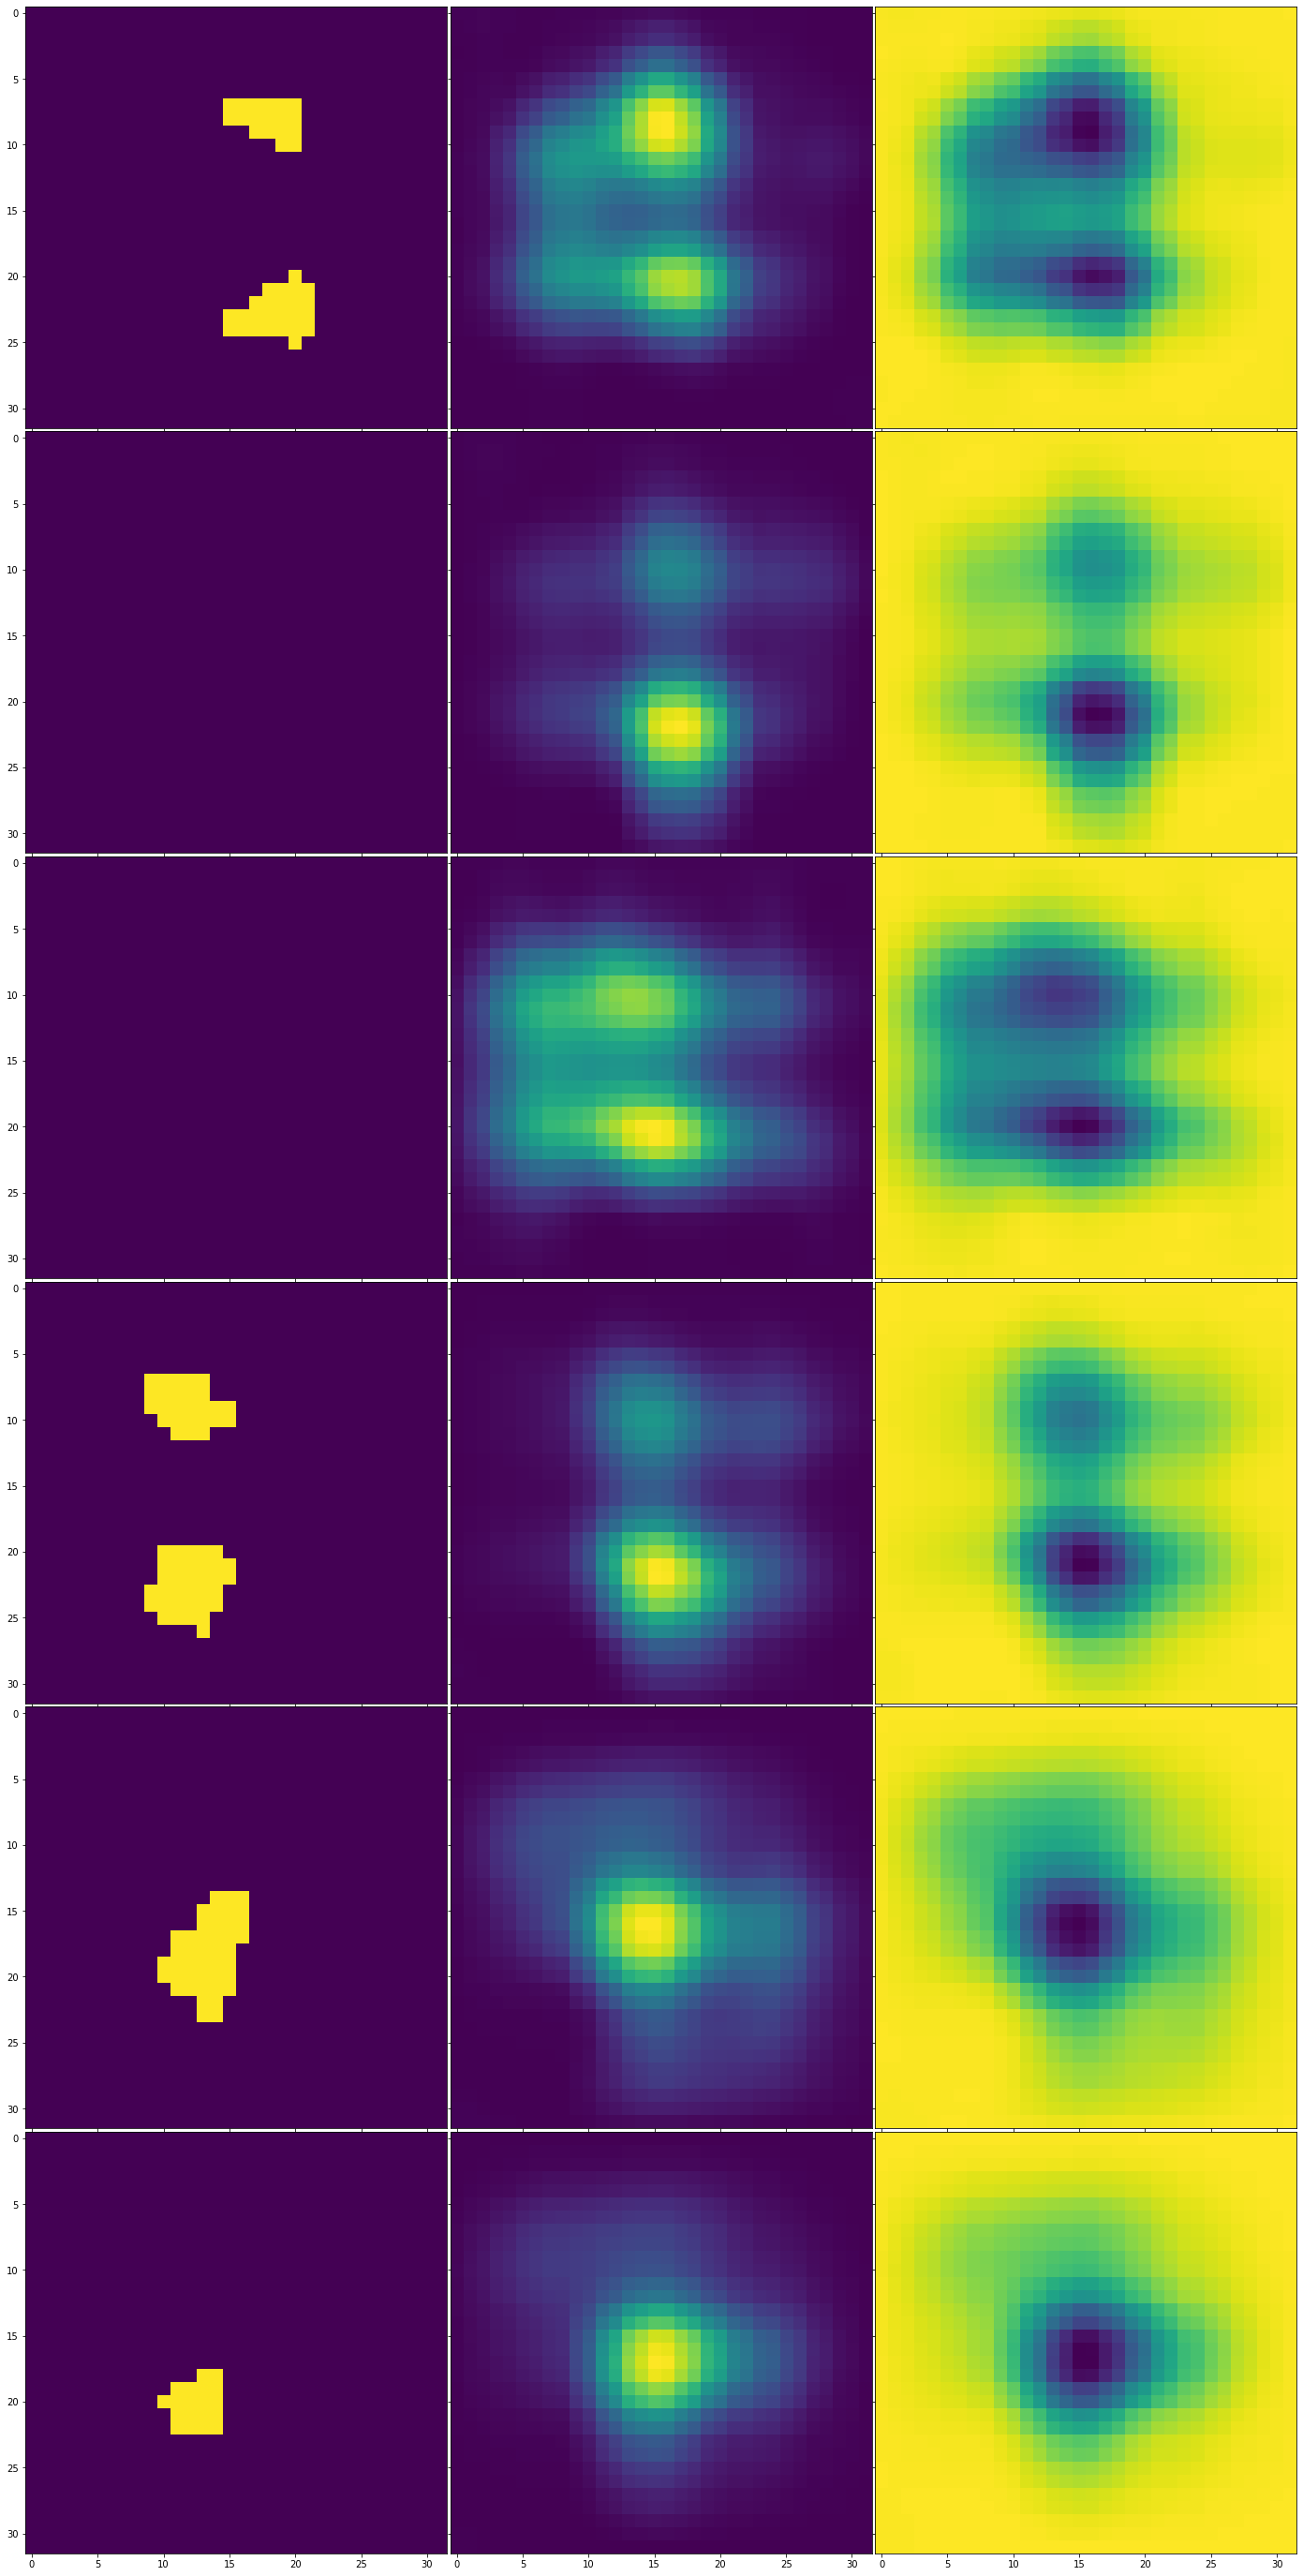

Epoch: 121, mask likelihood: 1.369856357574463, KL: 8.511, accuracy: 1.3699, recon likelihood: 550.9135131835938
Epoch: 122, mask likelihood: 1.3734958171844482, KL: 8.437, accuracy: 1.3735, recon likelihood: 548.990234375
Epoch: 123, mask likelihood: 1.3738958835601807, KL: 8.466, accuracy: 1.3739, recon likelihood: 554.9693603515625
Epoch: 124, mask likelihood: 1.3725858926773071, KL: 8.517, accuracy: 1.3726, recon likelihood: 529.3317260742188
Epoch: 125, mask likelihood: 1.3753018379211426, KL: 8.734, accuracy: 1.3753, recon likelihood: 539.3370971679688
Epoch: 126, mask likelihood: 1.3787310123443604, KL: 8.98, accuracy: 1.3787, recon likelihood: 530.3942260742188
Epoch: 127, mask likelihood: 1.3789303302764893, KL: 8.984, accuracy: 1.3789, recon likelihood: 519.3904418945312
Epoch: 128, mask likelihood: 1.3786572217941284, KL: 8.945, accuracy: 1.3787, recon likelihood: 533.7968139648438
Epoch: 129, mask likelihood: 1.3749481439590454, KL: 9.33, accuracy: 1.3749, recon likelihood:

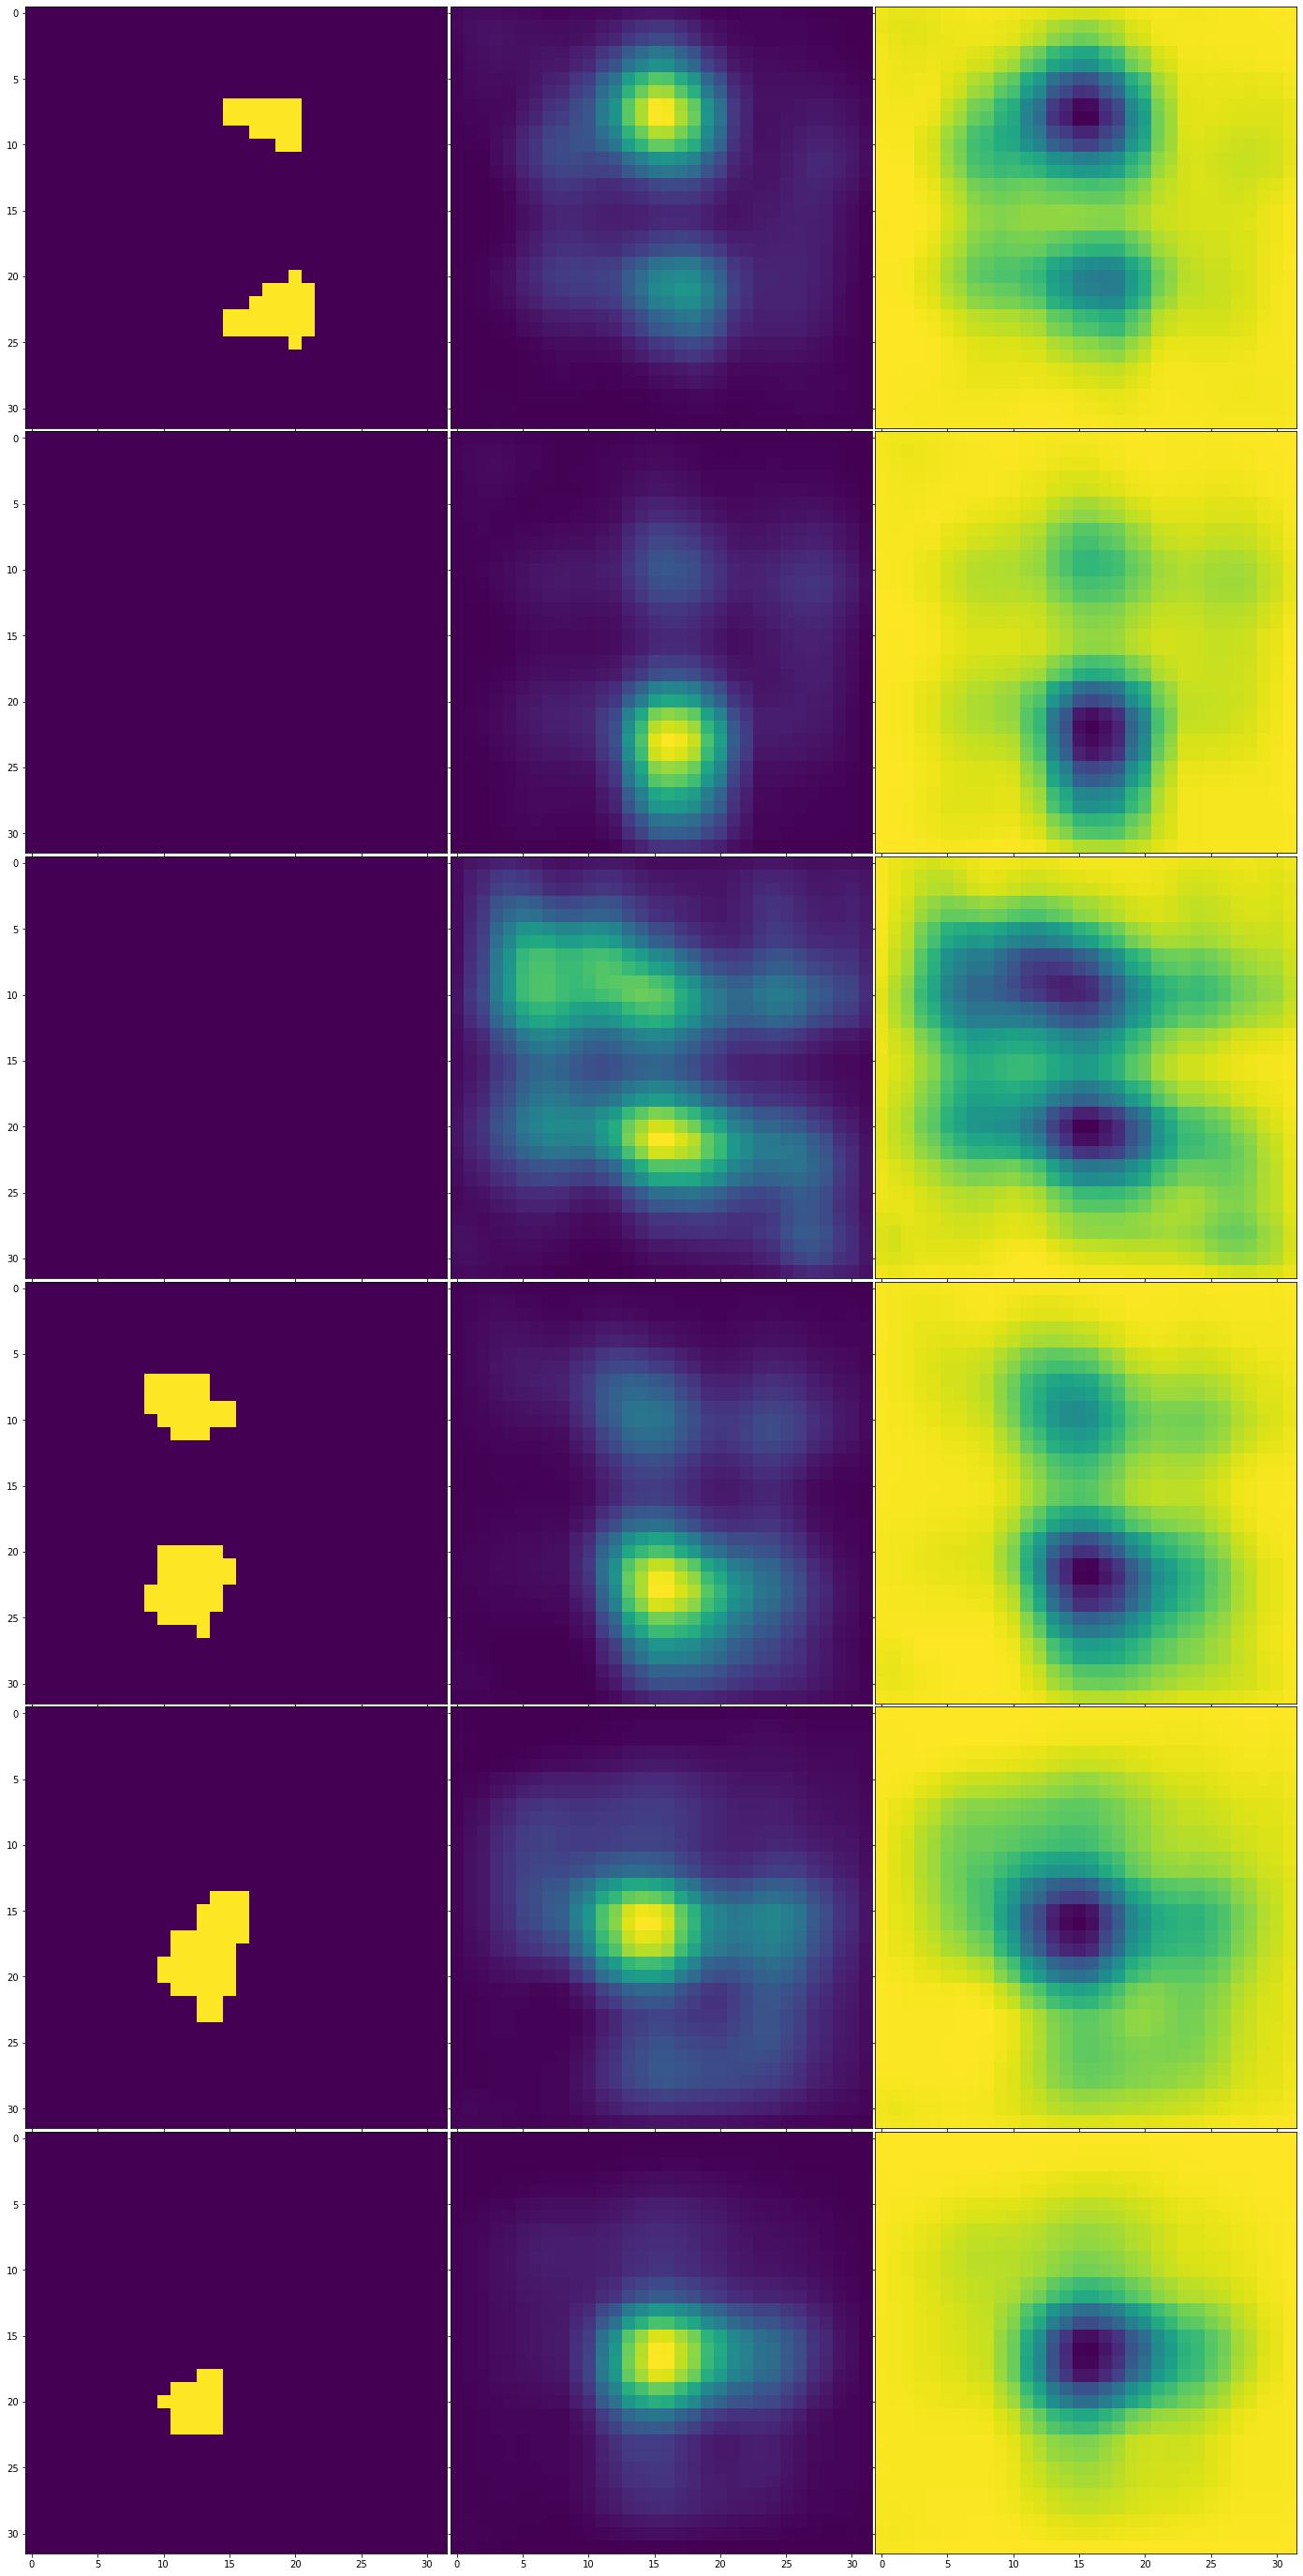

Epoch: 141, mask likelihood: 1.3755292892456055, KL: 10.369, accuracy: 1.3755, recon likelihood: 494.0472412109375
Epoch: 142, mask likelihood: 1.376306176185608, KL: 10.48, accuracy: 1.3763, recon likelihood: 497.6748352050781
Epoch: 143, mask likelihood: 1.3769525289535522, KL: 10.488, accuracy: 1.377, recon likelihood: 497.90283203125
Epoch: 144, mask likelihood: 1.3770501613616943, KL: 10.617, accuracy: 1.3771, recon likelihood: 496.99462890625
Epoch: 145, mask likelihood: 1.3774441480636597, KL: 10.608, accuracy: 1.3774, recon likelihood: 483.0543518066406
Epoch: 146, mask likelihood: 1.3763091564178467, KL: 10.747, accuracy: 1.3763, recon likelihood: 512.965087890625
Epoch: 147, mask likelihood: 1.3767282962799072, KL: 10.851, accuracy: 1.3767, recon likelihood: 485.361328125
Epoch: 148, mask likelihood: 1.3766268491744995, KL: 10.745, accuracy: 1.3766, recon likelihood: 480.648193359375
Epoch: 149, mask likelihood: 1.3752752542495728, KL: 10.947, accuracy: 1.3753, recon likeliho

KeyboardInterrupt: 

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Tensor = torch.cuda.FloatTensor

model = ModelWrapper(config['input_size'],
                         z_dim=config['z_dim'],
                         start_dims=config['start_dims'],
                         continuous=config['continuous']).to(device)

num_epochs = config['epochs']

# Other optimisers work as well, Adamax is quite stable though
optimizer = optim.Adamax(model.parameters(), weight_decay=config['wd'], lr=config['lr'])

print('NUM PARAMS: {}'.format(count_parameters(model)))
print(f'NUM EPOCHS: {num_epochs}')

best_loss = 1e30
best_acc = 0
best_lk = 1e30
global_step = 0

for epoch in range(num_epochs):
    model.zero_grad()
    train_acc = 0

    # The trackers for the mean and scale of the inference map
    vae_mask = np.zeros((config['input_size'], config['input_size'], config['input_size']))
    vae_scale = np.zeros((config['input_size'], config['input_size'], config['input_size']))

    for (x, y) in train_loader:
        optimizer.zero_grad()

        x = x.type(Tensor).to(device)
        y = y.type(Tensor).to(device)

        ret_dict = model(x, y)

        loss = ret_dict['loss'].mean()

        loss.backward()
        optimizer.step()

        vae_mask += np.squeeze(ret_dict['mean_mask'].cpu().data.numpy())
        vae_scale += np.squeeze(ret_dict['mask_scale'].cpu().data.numpy())
        train_acc += 1
        global_step += 1

    vae_mask = vae_mask / train_acc
    val_mask = tc.from_numpy(vae_mask).type(Tensor).to(device).view(1, 1,
                                                                    config['input_size'],
                                                                    config['input_size'],
                                                                    config['input_size'])
    vae_scale = vae_scale / train_acc
    val_scale = tc.from_numpy(vae_scale).type(Tensor).to(device).view(1, 1,
                                                                    config['input_size'],
                                                                    config['input_size'],
                                                                    config['input_size'])

    val_acc = 0
    accuracy_acc = 0
    loss_acc = 0
    likelihood_acc = 0
    kld_acc = 0
    recon_acc = 0
    with torch.no_grad():
        for (x, y) in val_loader:
            x = x.type(Tensor).to(device)
            y = y.type(Tensor).to(device)

            ret_dict = model(x, y,
                             provided_mask=val_mask,
                             provided_scale=val_scale,
                             val=True)

            loss_acc += ret_dict['loss'].mean().item()
            val_acc += 1
            likelihood_acc += ret_dict['mask_ll'].item()
            accuracy_acc += ret_dict['acc'].item()
            kld_acc += ret_dict['kl'].item()
            recon_acc += ret_dict['recon_ll'].item()

    loss = loss_acc / val_acc
    lk = likelihood_acc / val_acc
    acc = round(accuracy_acc / val_acc, 4)
    kl = round(kld_acc / val_acc, 3)
    rec = recon_acc / val_acc

    print(f'Epoch: {epoch}, mask likelihood: {lk}, KL: {kl}, accuracy: {acc}, recon likelihood: {rec}')
    
    if lk < best_lk:
        best_loss = loss
        best_lk = lk
        best_acc = acc
        best_recon = recon_acc
        best_epoch = epoch
        torch.save(model, f"vae.pth")
        np.save(f'vae_mask.npy', vae_mask)
        np.save(f'vae_scale.npy', vae_scale)
    
    if epoch % 10 == 0:
        print(f'Best: {best_lk}, {best_loss}, {best_acc}, epoch: {best_epoch}')
        
    # VIZUALISE AS THE TRAINING GOES ON
    if epoch % 20 == 0:

        subtitle_fontsize = 30

        fig = plt.figure(figsize=(50., 50.))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(6, 3),  # creates 2x2 grid of axes
                         axes_pad=0.05,  # pad between axes in inch.
                         )

        imgs = x.cpu().data.numpy()

        question_mark = ret_dict['mean_mask'].cpu().data.numpy()

        b, c, h, w, d = imgs.shape
        imgs = np.reshape(imgs, [-1, h, w, d])
        question_mark = np.reshape(question_mark, [-1, h, w, d])
        mask_scale = np.reshape(vae_mask, [1, h, w, d])

        acc = 0
        for l in range(3):
            for v in [10, 20]:
                if l == 0:
                    grid[acc].imshow(gt[:, :, v])
                elif l == 1:
                    grid[acc].imshow(gt[:, v, :])
                else:
                    grid[acc].imshow(gt[v, :, :])
                if i == 0:
                    grid[acc].set_title("GT", fontsize=subtitle_fontsize,
                                        loc='center', color = "k")
                acc +=1

                if l == 0:
                    grid[acc].imshow(vae_mask[:, :, v])
                elif l == 1:
                    grid[acc].imshow(vae_mask[:, v, :])
                else:
                    grid[acc].imshow(vae_mask[v, :, :])
                    
                if i == 0:
                    grid[acc].set_title("Mean substrate mask", fontsize=subtitle_fontsize,
                                        loc='center', color = "k")
                acc +=1
                
                if l == 0:
                    grid[acc].imshow(vae_scale[:, :, v])
                elif l == 1:
                    grid[acc].imshow(vae_scale[:, v, :])
                else:
                    grid[acc].imshow(vae_scale[v, :, :])

                if i == 0:
                    grid[acc].set_title("STD substrate mask",
                                                fontsize=subtitle_fontsize, loc='center', color = "k")
                acc += 1

        plt.show()

In [10]:
# CALIBRATE OUR MASK

# model = ModelWrapper(np.mean(data, axis=0)).to(device)
model = torch.load("vae.pth")
model.eval()
vae_mask = np.load('vae_mask.npy')
vae_mask[:, :2, :] = 0
vae_mask[:2, :, :] = 0
vae_mask[:, :, :2] = 0

vae_mask[:, -2:, :] = 0
vae_mask[-2:, :, :] = 0
vae_mask[:, :, -2:] = 0

best_threshold = 0
best_acc = 1e30

threshold_range = np.linspace(0.95, 0.99, num=20)
for thresh in threshold_range:
    with torch.no_grad():
        counter = 0
        accuracy = 0
        for (x, y) in val_loader:
            x = x.type(Tensor).to(device)
            y = y.type(Tensor).to(device)
            ret_dict = model(x, y,
                             calibrate=True,
                             t=float(thresh))

            accuracy += ret_dict['acc']
            counter += 1
        accuracy = accuracy / counter
        print(f'{thresh}, {accuracy}')
        if accuracy < best_acc:
            best_acc = accuracy
            best_threshold = thresh
    
# FIND THE BEST THRESHOLD
t = np.quantile(vae_mask, best_threshold)
vae_mask = (vae_mask > t) * vae_mask

0.95, 1.2351844310760498
0.9521052631578947, 1.20845365524292
0.9542105263157894, 1.204737901687622
0.9563157894736841, 1.1893343925476074
0.958421052631579, 1.2068936824798584
0.9605263157894737, 1.2232277393341064
0.9626315789473684, 1.2114408016204834
0.9647368421052631, 1.229229211807251
0.9668421052631578, 1.2408537864685059
0.9689473684210526, 1.2576730251312256
0.9710526315789474, 1.2648004293441772
0.9731578947368421, 1.2520760297775269
0.9752631578947368, 1.2524393796920776
0.9773684210526316, 1.2524446249008179
0.9794736842105263, 1.2516039609909058
0.981578947368421, 1.2811880111694336
0.9836842105263157, 1.3152053356170654
0.9857894736842105, 1.2872895002365112
0.9878947368421053, 1.3012133836746216
0.99, 1.3902450799942017


In [11]:
# RUN SVR-LSM APPROXIMATION FOR DEBUGGING PURPOSES
from sklearn import svm

continuous = True

svm_data = np.reshape(train_data, [train_data.shape[0], train_data.shape[2]**3])

svr_labels = train_labels
if continuous:
    svr_labels = (train_labels - train_labels.mean())
    svr_labels = svr_labels / svr_labels.std()
svm_data = svm_data / (np.linalg.norm(svm_data, axis=-1, keepdims=True) + 1e-5)

if continuous:
    svm = svm.SVR(kernel='rbf', C=0.8)
else:
    svm = svm.SVC(kernel='rbf')
svm.fit(svm_data, svr_labels)

alphas = svm.dual_coef_

backprojection = alphas * np.transpose(svm.support_vectors_)
backprojection = np.sum(backprojection, axis=1)
svm_preds = np.reshape(backprojection, [train_data.shape[2], train_data.shape[2],
                                        train_data.shape[2]])
svm_preds.shape

(32, 32, 32)

In [12]:
# RUN VLSM APPROXIMATION FOR DEBUGGING PURPOSES

idxs_p = np.where(train_labels > 0)
idxs_n = np.where(train_labels == 0)
img_size = 32

fisher_preds = np.zeros((img_size, img_size, img_size))
for i in range(img_size):
    for j in range(img_size):
        for k in range(img_size):
            index_vox = train_data[:, 0, i, j, k]

            table = np.zeros((2, 2))
            table[0, 0] = np.sum(index_vox[idxs_n] == 0)
            table[0, 1] = np.sum(index_vox[idxs_n] > 0)
            table[1, 0] = np.sum(index_vox[idxs_p] == 0)
            table[1, 1] = np.sum(index_vox[idxs_p] > 0)

            p_value = scipy.stats.fisher_exact(table, 'greater')[-1]
            fisher_preds[i, j, k] = p_value

fisher_preds = - np.log(fisher_preds)
univar_preds = fisher_preds

In [13]:
def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [14]:
from monai.metrics import compute_hausdorff_distance, compute_average_surface_distance

'''
THIS IS JUST FOR DEBUGGING PURPOSES
FOR PROPER EVALUATION YOU'LL HAVE TO GET P-VALUES FOR VLSM AND SVR-LSM 
AND THEN USE FWER/FDR
'''

results = {'VDVAE-LDM': vae_mask, 'VLSM': univar_preds, 'SVR-LSM': svm_preds}

keys = ['VDVAE-LDM', 'VLSM', 'SVR-LSM']
thresholds = {}
for k in keys:
    thresholds[k] = {'dice': [0, 0], 'hausdorff': [1e10, 0], 'asd': [1e10, 0],
                    }

for k in results:
    results[k] = results[k] - results[k].min()
    results[k] = results[k] / (results[k].max())

# threshold_range = np.linspace(0.8, 0.98, num=20)
threshold_range = [0.9]

for thresh in threshold_range:
    for k in thresholds:
        t = np.quantile(results[k], thresh)
        bin_res = results[k] > t

        preds = np.expand_dims(np.expand_dims(results[k], axis=0), axis=0)
        bin_preds = np.expand_dims(np.expand_dims(bin_res, axis=0), axis=0)
        monai_gt = np.expand_dims(np.expand_dims(gt, axis=0), axis=0)
        
        dice_s = dice(bin_res, gt)
            
        if dice_s > thresholds[k]['dice'][0]:
            thresholds[k]['dice'][0] = round(dice_s, 2)
            if k == 'VDVAE-LDM':
                thresholds[k]['dice'][1] = best_threshold
            else:
                thresholds[k]['dice'][1] = thresh
            
            haus = compute_hausdorff_distance(bin_preds, monai_gt).numpy()[0][0]
            asd = compute_average_surface_distance(bin_preds, monai_gt,
                                                   symmetric=False).numpy()[0][0]
            
            thresholds[k]['hausdorff'][0] = round(haus, 2)
            thresholds[k]['hausdorff'][1] = thresh
            
            thresholds[k]['asd'][0] = round(asd, 2)
            thresholds[k]['asd'][1] = thresh
            
            
thresholds

{'VDVAE-LDM': {'dice': [0.29, 0.9563157894736841],
  'hausdorff': [6.16, 0.9],
  'asd': [2.7, 0.9]},
 'VLSM': {'dice': [0.19, 0.9], 'hausdorff': [11.18, 0.9], 'asd': [4.5, 0.9]},
 'SVR-LSM': {'dice': [0.15, 0.9],
  'hausdorff': [13.38, 0.9],
  'asd': [4.57, 0.9]}}